In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Converting edf to csv file which contains spectral characteristics and start and end time of clean and artifacts segments.

In [2]:
import os
import numpy as np
import pandas as pd
import mne
from scipy import signal
import random
from tqdm import tqdm

# Configuration
input_dir = '/kaggle/input/eeg-signals-edf-dataset/edf/01_tcp_ar'
output_csv = '/kaggle/working/balanced_artifact_features.csv'
# Number of clean segments to extract per artifact segment
CLEAN_TO_ARTIFACT_RATIO = 1  # 1:1 ratio, adjust as needed
# Minimum duration (in seconds) for a segment to be considered valid
MIN_SEGMENT_DURATION = 0.5
# Maximum duration (in seconds) for a segment to be extracted
MAX_SEGMENT_DURATION = 5.0

def read_annotations(csv_path):
    """Read annotation CSV with proper header handling"""
    try:
        with open(csv_path, 'r') as f:
            lines = [line.strip() for line in f if line.strip()]
        
        header_idx = next((i for i, line in enumerate(lines) if not line.startswith('#')), 0)
        
        # Try to detect the delimiter by examining the header line
        header_line = lines[header_idx] if header_idx < len(lines) else ""
        delimiter = '\t'  # Default delimiter
        
        if ',' in header_line and '\t' not in header_line:
            delimiter = ','
        
        df = pd.read_csv(csv_path, sep=delimiter, skiprows=header_idx, comment='#')
        
        required_columns = ['start_time', 'stop_time', 'channel', 'label']
        
        if not all(col in df.columns for col in required_columns):
            column_map = {
                'start': 'start_time',
                'stop': 'stop_time',
                'electrode': 'channel',
                'artifact': 'label',
                'type': 'label'
            }
            
            for alt_col, std_col in column_map.items():
                if alt_col in df.columns and std_col not in df.columns:
                    df = df.rename(columns={alt_col: std_col})
        
        missing_columns = [col for col in required_columns if col not in df.columns]
        if missing_columns:
            print(f"CSV missing required columns: {missing_columns}")
            print(f"Available columns: {df.columns.tolist()}")
            raise ValueError(f"Missing required columns in {os.path.basename(csv_path)}")
            
        return df
        
    except Exception as e:
        print(f"Error reading annotation file {os.path.basename(csv_path)}: {str(e)}")
        raise

def find_matching_channel(annotation_channel, edf_channels):
    """Find a matching channel between annotation and EDF file"""
    # Direct match
    if annotation_channel in edf_channels:
        return annotation_channel
        
    # Try common transformations
    transformed_channels = [
        annotation_channel.replace('-', ' '),
        annotation_channel.replace('-', '_'),
        annotation_channel.split('-')[0] if '-' in annotation_channel else None,
        annotation_channel.lower(),
        annotation_channel.upper()
    ]
    
    transformed_channels = [c for c in transformed_channels if c is not None]
    
    for channel in transformed_channels:
        if channel in edf_channels:
            return channel
            
    # Special case: some systems might use 'EEG channel-REF' format
    if '-' in annotation_channel:
        ch_parts = annotation_channel.split('-')
        for edf_ch in edf_channels:
            if ch_parts[0] in edf_ch:
                return edf_ch
    
    return None

def extract_spectral_features(data, sfreq):
    """Calculate spectral features for a data segment"""
    nperseg = min(256, len(data))
    if nperseg < 8:
        return None
        
    freqs, psd = signal.welch(data, fs=sfreq, nperseg=nperseg)
    
    # Define frequency bands
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 50)
    }
    
    features = {}
    # Calculate band powers and ratios
    band_powers = {}
    for band, (fmin, fmax) in bands.items():
        band_mask = (freqs >= fmin) & (freqs <= fmax)
        if any(band_mask):
            band_power = np.mean(psd[band_mask])
            features[f'{band}_power'] = band_power
            features[f'{band}_peak_freq'] = freqs[band_mask][np.argmax(psd[band_mask])] if any(band_mask) else np.nan
            band_powers[band] = band_power
        else:
            features[f'{band}_power'] = np.nan
            features[f'{band}_peak_freq'] = np.nan
            band_powers[band] = 0
    
    # Calculate band power ratios (useful for artifact detection)
    if band_powers['alpha'] > 0:  # Avoid division by zero
        features['beta_alpha_ratio'] = band_powers['beta'] / band_powers['alpha']
    else:
        features['beta_alpha_ratio'] = np.nan
        
    if band_powers['delta'] > 0:  # Avoid division by zero
        features['theta_delta_ratio'] = band_powers['theta'] / band_powers['delta']
    else:
        features['theta_delta_ratio'] = np.nan
    
    # Overall spectral properties
    features['total_power'] = np.sum(psd[(freqs >= 0.5) & (freqs <= 50)])
    features['peak_frequency'] = freqs[np.argmax(psd)]
    features['peak_power'] = np.max(psd)
    
    # Time domain features
    features['variance'] = np.var(data)
    features['mean_abs_amplitude'] = np.mean(np.abs(data))
    features['zero_crossings'] = np.sum(np.diff(np.signbit(data).astype(int)) != 0)
    
    return features

def find_clean_segments(raw, artifact_intervals, channel, n_segments=1, min_duration=1.0, max_duration=5.0):
    """Find clean segments not overlapping with artifacts"""
    total_duration = raw.times[-1]
    sfreq = raw.info['sfreq']
    
    # Sort intervals by start time
    artifact_intervals = sorted(artifact_intervals, key=lambda x: x[0])
    
    # Find gaps between artifacts
    clean_intervals = []
    last_end = 0
    
    for start, end in artifact_intervals:
        # If there's a gap between last artifact and current one
        if start > last_end + min_duration:
            clean_intervals.append((last_end, start))
        last_end = max(last_end, end)
    
    # Add the final interval if there's space
    if total_duration > last_end + min_duration:
        clean_intervals.append((last_end, total_duration))
    
    # If no clean intervals found or they're too short
    if not clean_intervals or all(end - start < min_duration for start, end in clean_intervals):
        # Try to find segments between artifacts
        clean_intervals = []
        for i in range(len(artifact_intervals) - 1):
            end_current = artifact_intervals[i][1]
            start_next = artifact_intervals[i + 1][0]
            if start_next - end_current >= min_duration:
                clean_intervals.append((end_current, start_next))
    
    # Still no suitable intervals? Return empty list
    if not clean_intervals:
        return []
    
    # Select random intervals
    selected_segments = []
    shuffled_intervals = random.sample(clean_intervals, min(len(clean_intervals), n_segments * 3))
    
    for start, end in shuffled_intervals:
        interval_duration = end - start
        
        # If interval is too long, pick a random segment within it
        if interval_duration > max_duration:
            max_start = end - max_duration
            segment_start = random.uniform(start, max_start)
            segment_end = segment_start + random.uniform(min_duration, max_duration)
        else:
            segment_start = start
            segment_end = end
        
        # Ensure minimum duration
        if segment_end - segment_start >= min_duration:
            selected_segments.append((segment_start, segment_end))
            
        # Stop once we have enough segments
        if len(selected_segments) >= n_segments:
            break
    
    return selected_segments

def process_file_pair(edf_path, csv_path):
    """Process one EDF-CSV pair to extract artifact and clean segments"""
    try:
        # Check if both files exist
        if not os.path.exists(edf_path) or not os.path.exists(csv_path):
            return []
            
        # Read data
        raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
        sfreq = raw.info['sfreq']
        edf_channels = raw.info['ch_names']
        
        try:
            annotations = read_annotations(csv_path)
        except Exception as e:
            print(f"Failed to read annotations for {os.path.basename(edf_path)}: {str(e)}")
            return []
        
        results = []
        processed_artifacts = 0
        processed_clean = 0
        
        # Process artifacts by channel
        channels_with_artifacts = {}
        for _, row in annotations.iterrows():
            ch = row['channel']
            if ch not in channels_with_artifacts:
                channels_with_artifacts[ch] = []
            channels_with_artifacts[ch].append((row['start_time'], row['stop_time'], row['label']))
        
        # Process each channel
        for annotation_channel, artifact_segments in channels_with_artifacts.items():
            # Find matching EDF channel
            edf_channel = find_matching_channel(annotation_channel, edf_channels)
            if edf_channel is None:
                continue
                
            # Extract artifact segments
            for start, stop, label in artifact_segments:
                # Skip segments that are too short
                if stop - start < MIN_SEGMENT_DURATION:
                    continue
                    
                # Cap segment duration if too long
                if stop - start > MAX_SEGMENT_DURATION:
                    mid_point = (start + stop) / 2
                    start = mid_point - MAX_SEGMENT_DURATION / 2
                    stop = mid_point + MAX_SEGMENT_DURATION / 2
                
                try:
                    data, _ = raw[edf_channel, int(start*sfreq):int(stop*sfreq)]
                    data = data.flatten()
                    
                    # Skip if empty
                    if len(data) == 0:
                        continue
                    
                    # Extract features
                    features = extract_spectral_features(data, sfreq)
                    if features is None:
                        continue
                    
                    # Add metadata
                    features.update({
                        'edf_file': os.path.basename(edf_path),
                        'channel': annotation_channel,
                        'edf_channel': edf_channel,
                        'artifact_type': label,
                        'is_artifact': 1,  # Binary label for ML
                        'start_time': start,
                        'stop_time': stop,
                        'duration': stop - start
                    })
                    
                    results.append(features)
                    processed_artifacts += 1
                except Exception as e:
                    print(f"Error processing artifact in {os.path.basename(edf_path)}: {str(e)}")
                    continue
            
            # Find matching clean segments for this channel
            artifact_intervals = [(start, stop) for start, stop, _ in artifact_segments]
            clean_segments = find_clean_segments(
                raw, 
                artifact_intervals, 
                edf_channel, 
                n_segments=len(artifact_segments) * CLEAN_TO_ARTIFACT_RATIO,
                min_duration=MIN_SEGMENT_DURATION,
                max_duration=MAX_SEGMENT_DURATION
            )
            
            # Extract clean segments
            for start, stop in clean_segments:
                try:
                    data, _ = raw[edf_channel, int(start*sfreq):int(stop*sfreq)]
                    data = data.flatten()
                    
                    # Skip if empty
                    if len(data) == 0:
                        continue
                    
                    # Extract features
                    features = extract_spectral_features(data, sfreq)
                    if features is None:
                        continue
                    
                    # Add metadata
                    features.update({
                        'edf_file': os.path.basename(edf_path),
                        'channel': annotation_channel,
                        'edf_channel': edf_channel,
                        'artifact_type': 'clean',  # Label as clean
                        'is_artifact': 0,  # Binary label for ML
                        'start_time': start,
                        'stop_time': stop,
                        'duration': stop - start
                    })
                    
                    results.append(features)
                    processed_clean += 1
                except Exception as e:
                    print(f"Error processing clean segment in {os.path.basename(edf_path)}: {str(e)}")
                    continue
        
        print(f"Processed {processed_artifacts} artifacts and {processed_clean} clean segments from {os.path.basename(edf_path)}")
        return results
    
    except Exception as e:
        print(f"Error processing {os.path.basename(edf_path)}: {str(e)}")
        return []

def main():
    # Get all EDF files
    edf_files = []
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.endswith('.edf'):
                edf_files.append(os.path.join(root, file))
    
    if not edf_files:
        print(f"No EDF files found in {input_dir}")
        return
    
    print(f"Found {len(edf_files)} EDF files to process")
    
    # Process all files
    all_results = []
    for edf_path in tqdm(edf_files):
        csv_path = edf_path.replace('.edf', '.csv')
        if os.path.exists(csv_path):
            results = process_file_pair(edf_path, csv_path)
            all_results.extend(results)
    
    # Save to CSV
    if all_results:
        df = pd.DataFrame(all_results)
        
        # Check class balance
        artifact_count = sum(df['is_artifact'] == 1)
        clean_count = sum(df['is_artifact'] == 0)
        print(f"Dataset summary: {artifact_count} artifacts, {clean_count} clean segments")
        print(f"Class balance: {clean_count / (artifact_count + clean_count):.2%} clean")
        
        df.to_csv(output_csv, index=False)
        print(f"Saved balanced dataset with {len(df)} segments to {output_csv}")
    else:
        print("No segments processed - check your input files")

if __name__ == '__main__':
    main()

Found 290 EDF files to process


  0%|          | 1/290 [00:04<20:50,  4.33s/it]

Processed 300 artifacts and 292 clean segments from aaaaadeu_s002_t000.edf


  1%|          | 2/290 [00:05<10:42,  2.23s/it]

Processed 120 artifacts and 120 clean segments from aaaaajqo_s033_t000.edf


  1%|          | 3/290 [00:05<07:11,  1.50s/it]

Processed 21 artifacts and 25 clean segments from aaaaacby_s004_t000.edf


  1%|▏         | 4/290 [00:06<05:08,  1.08s/it]

Processed 179 artifacts and 164 clean segments from aaaaajrj_s006_t007.edf


  2%|▏         | 5/290 [00:09<08:40,  1.83s/it]

Processed 2167 artifacts and 849 clean segments from aaaaafhl_s003_t000.edf


  2%|▏         | 6/290 [00:10<07:34,  1.60s/it]

Processed 292 artifacts and 269 clean segments from aaaaanta_s001_t000.edf


  2%|▏         | 7/290 [00:11<06:18,  1.34s/it]

Processed 70 artifacts and 201 clean segments from aaaaajrf_s002_t000.edf


  3%|▎         | 8/290 [00:13<06:59,  1.49s/it]

Processed 585 artifacts and 795 clean segments from aaaaamnq_s001_t000.edf


  3%|▎         | 9/290 [00:14<07:27,  1.59s/it]

Processed 1201 artifacts and 408 clean segments from aaaaamcr_s003_t010.edf


  3%|▎         | 10/290 [00:16<07:00,  1.50s/it]

Processed 222 artifacts and 250 clean segments from aaaaanlp_s001_t000.edf


  4%|▍         | 11/290 [00:17<06:06,  1.32s/it]

Processed 65 artifacts and 147 clean segments from aaaaaizu_s001_t001.edf


  4%|▍         | 12/290 [00:18<05:33,  1.20s/it]

Processed 97 artifacts and 303 clean segments from aaaaajrf_s003_t002.edf


  4%|▍         | 13/290 [00:18<04:16,  1.08it/s]

Processed 116 artifacts and 111 clean segments from aaaaabiw_s017_t000.edf


  5%|▍         | 14/290 [00:19<04:35,  1.00it/s]

Processed 274 artifacts and 296 clean segments from aaaaaiby_s001_t000.edf


  5%|▌         | 15/290 [00:21<06:07,  1.34s/it]

Processed 829 artifacts and 829 clean segments from aaaaaovn_s002_t005.edf


  6%|▌         | 16/290 [00:24<08:52,  1.94s/it]

Processed 738 artifacts and 869 clean segments from aaaaaijh_s002_t000.edf


  6%|▌         | 17/290 [00:25<06:58,  1.53s/it]

Processed 200 artifacts and 325 clean segments from aaaaaimu_s008_t000.edf


  6%|▌         | 18/290 [00:27<07:36,  1.68s/it]

Processed 472 artifacts and 417 clean segments from aaaaajns_s001_t001.edf


  7%|▋         | 19/290 [00:28<06:55,  1.53s/it]

Processed 566 artifacts and 557 clean segments from aaaaalzg_s006_t001.edf


  7%|▋         | 20/290 [00:29<06:26,  1.43s/it]

Processed 369 artifacts and 362 clean segments from aaaaapks_s009_t000.edf


  7%|▋         | 21/290 [00:30<05:40,  1.27s/it]

Processed 173 artifacts and 175 clean segments from aaaaalth_s002_t001.edf


  8%|▊         | 22/290 [00:31<04:46,  1.07s/it]

Processed 137 artifacts and 143 clean segments from aaaaanji_s001_t000.edf
Processed 6 artifacts and 6 clean segments from aaaaabbn_s009_t003.edf


  8%|▊         | 24/290 [00:32<03:30,  1.26it/s]

Processed 146 artifacts and 170 clean segments from aaaaakft_s001_t000.edf


  9%|▊         | 25/290 [00:32<03:18,  1.33it/s]

Processed 341 artifacts and 351 clean segments from aaaaajrj_s004_t008.edf


  9%|▉         | 26/290 [00:33<03:21,  1.31it/s]

Processed 169 artifacts and 164 clean segments from aaaaaovo_s001_t000.edf


  9%|▉         | 27/290 [00:34<03:33,  1.23it/s]

Processed 287 artifacts and 275 clean segments from aaaaaosh_s001_t000.edf


 10%|▉         | 28/290 [00:35<03:42,  1.18it/s]

Processed 489 artifacts and 313 clean segments from aaaaaoxr_s004_t004.edf


 10%|█         | 29/290 [00:36<03:37,  1.20it/s]

Processed 194 artifacts and 104 clean segments from aaaaajzm_s004_t000.edf


 10%|█         | 30/290 [00:39<06:32,  1.51s/it]

Processed 2012 artifacts and 1608 clean segments from aaaaajoa_s001_t001.edf


 11%|█         | 31/290 [00:41<07:15,  1.68s/it]

Processed 700 artifacts and 706 clean segments from aaaaapks_s008_t000.edf


 11%|█         | 32/290 [00:42<05:42,  1.33s/it]

Processed 110 artifacts and 117 clean segments from aaaaanrc_s002_t002.edf


 11%|█▏        | 33/290 [00:43<05:01,  1.17s/it]

Processed 132 artifacts and 121 clean segments from aaaaaoeg_s001_t000.edf


 12%|█▏        | 34/290 [00:44<04:46,  1.12s/it]

Processed 156 artifacts and 156 clean segments from aaaaabsk_s007_t000.edf


 12%|█▏        | 35/290 [00:46<06:06,  1.44s/it]

Processed 1382 artifacts and 737 clean segments from aaaaamcr_s003_t001.edf


 12%|█▏        | 36/290 [00:47<05:25,  1.28s/it]

Processed 484 artifacts and 367 clean segments from aaaaamhb_s010_t005.edf


 13%|█▎        | 37/290 [00:49<07:06,  1.69s/it]

Processed 1439 artifacts and 1258 clean segments from aaaaanyw_s002_t000.edf


 13%|█▎        | 38/290 [00:50<06:19,  1.51s/it]

Processed 410 artifacts and 436 clean segments from aaaaajoe_s001_t001.edf


 13%|█▎        | 39/290 [00:53<07:24,  1.77s/it]

Processed 970 artifacts and 902 clean segments from aaaaamob_s001_t000.edf


 14%|█▍        | 40/290 [00:53<05:51,  1.41s/it]

Processed 252 artifacts and 294 clean segments from aaaaaozv_s002_t000.edf


 14%|█▍        | 41/290 [00:54<05:07,  1.23s/it]

Processed 82 artifacts and 105 clean segments from aaaaajys_s001_t001.edf


 14%|█▍        | 42/290 [00:56<05:53,  1.42s/it]

Processed 543 artifacts and 560 clean segments from aaaaaons_s002_t002.edf


 15%|█▍        | 43/290 [00:57<05:19,  1.29s/it]

Processed 361 artifacts and 328 clean segments from aaaaaelb_s003_t000.edf


 15%|█▌        | 44/290 [00:58<05:17,  1.29s/it]

Processed 454 artifacts and 409 clean segments from aaaaanvg_s001_t002.edf


 16%|█▌        | 45/290 [00:59<04:53,  1.20s/it]

Processed 223 artifacts and 245 clean segments from aaaaapmp_s001_t000.edf


 16%|█▌        | 46/290 [01:00<04:21,  1.07s/it]

Processed 70 artifacts and 70 clean segments from aaaaabdo_s003_t000.edf


 16%|█▌        | 47/290 [01:01<03:54,  1.04it/s]

Processed 44 artifacts and 44 clean segments from aaaaahzm_s001_t001.edf


 17%|█▋        | 48/290 [01:02<03:57,  1.02it/s]

Processed 302 artifacts and 314 clean segments from aaaaapkx_s001_t001.edf


 17%|█▋        | 49/290 [01:03<04:17,  1.07s/it]

Processed 533 artifacts and 498 clean segments from aaaaanqe_s001_t000.edf


 17%|█▋        | 50/290 [01:04<04:18,  1.08s/it]

Processed 483 artifacts and 496 clean segments from aaaaaoxr_s004_t002.edf


 18%|█▊        | 52/290 [01:05<02:59,  1.33it/s]

Processed 183 artifacts and 205 clean segments from aaaaajuh_s001_t000.edf
Processed 16 artifacts and 16 clean segments from aaaaabbn_s010_t001.edf


 18%|█▊        | 53/290 [01:06<02:59,  1.32it/s]

Processed 226 artifacts and 202 clean segments from aaaaanrc_s004_t008.edf


 19%|█▊        | 54/290 [01:08<04:27,  1.13s/it]

Processed 480 artifacts and 471 clean segments from aaaaanyb_s001_t001.edf


 19%|█▉        | 55/290 [01:09<04:02,  1.03s/it]

Processed 52 artifacts and 52 clean segments from aaaaaarq_s004_t001.edf


 19%|█▉        | 56/290 [01:11<05:27,  1.40s/it]

Processed 1292 artifacts and 775 clean segments from aaaaahte_s002_t000.edf


 20%|█▉        | 57/290 [01:13<06:01,  1.55s/it]

Processed 519 artifacts and 565 clean segments from aaaaalbt_s002_t000.edf


 20%|██        | 58/290 [01:14<05:12,  1.35s/it]

Processed 247 artifacts and 366 clean segments from aaaaaogd_s008_t004.edf


 20%|██        | 59/290 [01:15<04:33,  1.19s/it]

Processed 142 artifacts and 184 clean segments from aaaaahte_s003_t000.edf


 21%|██        | 60/290 [01:15<03:58,  1.04s/it]

Processed 215 artifacts and 205 clean segments from aaaaaayg_s002_t001.edf


 21%|██        | 61/290 [01:16<04:12,  1.10s/it]

Processed 579 artifacts and 568 clean segments from aaaaajrj_s003_t012.edf


 21%|██▏       | 62/290 [01:18<04:30,  1.18s/it]

Processed 333 artifacts and 223 clean segments from aaaaamhb_s001_t001.edf


 22%|██▏       | 63/290 [01:19<03:58,  1.05s/it]

Processed 192 artifacts and 193 clean segments from aaaaamon_s001_t000.edf


 22%|██▏       | 64/290 [01:20<04:27,  1.19s/it]

Processed 643 artifacts and 616 clean segments from aaaaamyb_s001_t001.edf


 22%|██▏       | 65/290 [01:21<03:56,  1.05s/it]

Processed 71 artifacts and 71 clean segments from aaaaamoa_s001_t000.edf


 23%|██▎       | 66/290 [01:22<04:00,  1.07s/it]

Processed 294 artifacts and 259 clean segments from aaaaapex_s001_t000.edf


 23%|██▎       | 67/290 [01:23<03:31,  1.06it/s]

Processed 47 artifacts and 47 clean segments from aaaaajam_s001_t000.edf


 23%|██▎       | 68/290 [01:23<03:09,  1.17it/s]

Processed 97 artifacts and 89 clean segments from aaaaakeq_s001_t000.edf


 24%|██▍       | 69/290 [01:25<03:54,  1.06s/it]

Processed 645 artifacts and 457 clean segments from aaaaaoav_s002_t000.edf


 24%|██▍       | 70/290 [01:25<03:26,  1.07it/s]

Processed 229 artifacts and 166 clean segments from aaaaaloy_s012_t002.edf


 24%|██▍       | 71/290 [01:26<03:29,  1.05it/s]

Processed 46 artifacts and 105 clean segments from aaaaakcy_s005_t001.edf


 25%|██▍       | 72/290 [01:29<05:10,  1.43s/it]

Processed 1212 artifacts and 1074 clean segments from aaaaansj_s001_t000.edf


 25%|██▌       | 73/290 [01:30<04:18,  1.19s/it]

Processed 4 artifacts and 4 clean segments from aaaaaall_s004_t000.edf


 26%|██▌       | 74/290 [01:31<04:22,  1.21s/it]

Processed 505 artifacts and 445 clean segments from aaaaamyy_s001_t001.edf


 26%|██▌       | 75/290 [01:32<04:15,  1.19s/it]

Processed 530 artifacts and 401 clean segments from aaaaamcr_s003_t002.edf


 26%|██▌       | 76/290 [01:36<06:45,  1.89s/it]

Processed 3080 artifacts and 242 clean segments from aaaaaiae_s001_t000.edf


 27%|██▋       | 77/290 [01:37<05:58,  1.68s/it]

Processed 278 artifacts and 262 clean segments from aaaaanzh_s001_t000.edf


 27%|██▋       | 78/290 [01:39<06:05,  1.72s/it]

Processed 552 artifacts and 702 clean segments from aaaaalsq_s001_t000.edf


 27%|██▋       | 79/290 [01:39<05:05,  1.45s/it]

Processed 161 artifacts and 171 clean segments from aaaaamqc_s001_t000.edf


 28%|██▊       | 80/290 [01:41<05:15,  1.50s/it]

Processed 556 artifacts and 380 clean segments from aaaaaezj_s007_t002.edf


 28%|██▊       | 81/290 [01:42<04:37,  1.33s/it]

Processed 226 artifacts and 272 clean segments from aaaaakqg_s001_t001.edf


 28%|██▊       | 82/290 [01:43<04:37,  1.34s/it]

Processed 529 artifacts and 548 clean segments from aaaaakxo_s001_t000.edf


 29%|██▊       | 83/290 [01:44<04:21,  1.26s/it]

Processed 461 artifacts and 560 clean segments from aaaaaels_s006_t006.edf


 29%|██▉       | 84/290 [01:46<04:24,  1.29s/it]

Processed 453 artifacts and 456 clean segments from aaaaapas_s001_t001.edf


 29%|██▉       | 85/290 [01:46<03:46,  1.11s/it]

Processed 148 artifacts and 163 clean segments from aaaaaouk_s001_t000.edf


 30%|██▉       | 86/290 [01:48<03:58,  1.17s/it]

Processed 568 artifacts and 514 clean segments from aaaaajoo_s002_t001.edf


 30%|███       | 87/290 [01:49<04:25,  1.31s/it]

Processed 844 artifacts and 416 clean segments from aaaaamzf_s001_t001.edf


 30%|███       | 88/290 [01:52<05:34,  1.66s/it]

Processed 216 artifacts and 260 clean segments from aaaaaicc_s004_t000.edf


 31%|███       | 89/290 [01:52<04:33,  1.36s/it]

Processed 165 artifacts and 155 clean segments from aaaaapmb_s002_t001.edf


 31%|███       | 90/290 [01:55<05:31,  1.66s/it]

Processed 1334 artifacts and 1206 clean segments from aaaaakcx_s001_t001.edf


 31%|███▏      | 91/290 [01:56<04:41,  1.42s/it]

Processed 241 artifacts and 145 clean segments from aaaaanzu_s001_t003.edf


 32%|███▏      | 92/290 [01:57<04:21,  1.32s/it]

Processed 175 artifacts and 325 clean segments from aaaaampz_s001_t000.edf


 32%|███▏      | 93/290 [01:57<03:34,  1.09s/it]

Processed 176 artifacts and 158 clean segments from aaaaanrc_s004_t004.edf


 32%|███▏      | 94/290 [01:59<04:35,  1.41s/it]

Processed 1148 artifacts and 1022 clean segments from aaaaakcv_s001_t001.edf


 33%|███▎      | 95/290 [02:01<05:10,  1.59s/it]

Processed 1006 artifacts and 818 clean segments from aaaaaktz_s001_t000.edf


 33%|███▎      | 96/290 [02:02<04:31,  1.40s/it]

Processed 299 artifacts and 321 clean segments from aaaaanwj_s002_t000.edf


 33%|███▎      | 97/290 [02:05<05:24,  1.68s/it]

Processed 1119 artifacts and 1019 clean segments from aaaaagsc_s003_t001.edf


 34%|███▍      | 98/290 [02:05<04:24,  1.38s/it]

Processed 105 artifacts and 102 clean segments from aaaaallc_s001_t001.edf


 34%|███▍      | 99/290 [02:07<04:38,  1.46s/it]

Processed 597 artifacts and 609 clean segments from aaaaakka_s001_t001.edf


 34%|███▍      | 100/290 [02:10<05:50,  1.84s/it]

Processed 1424 artifacts and 1114 clean segments from aaaaamhb_s006_t005.edf


 35%|███▍      | 101/290 [02:12<05:56,  1.89s/it]

Processed 692 artifacts and 725 clean segments from aaaaaowf_s001_t000.edf


 35%|███▌      | 102/290 [02:15<07:21,  2.35s/it]

Processed 1400 artifacts and 1047 clean segments from aaaaanhb_s003_t001.edf


 36%|███▌      | 103/290 [02:17<07:06,  2.28s/it]

Processed 929 artifacts and 869 clean segments from aaaaaibx_s001_t000.edf


 36%|███▌      | 104/290 [02:21<08:39,  2.79s/it]

Processed 2519 artifacts and 2359 clean segments from aaaaamob_s002_t007.edf


 36%|███▌      | 105/290 [02:22<06:59,  2.27s/it]

Processed 223 artifacts and 232 clean segments from aaaaalqa_s001_t000.edf


 37%|███▋      | 106/290 [02:24<06:10,  2.01s/it]

Processed 698 artifacts and 702 clean segments from aaaaapcr_s006_t004.edf


 37%|███▋      | 107/290 [02:24<04:47,  1.57s/it]

Processed 8 artifacts and 74 clean segments from aaaaaovl_s001_t000.edf


 37%|███▋      | 108/290 [02:25<04:19,  1.42s/it]

Processed 269 artifacts and 264 clean segments from aaaaakqr_s001_t000.edf


 38%|███▊      | 109/290 [02:27<04:12,  1.40s/it]

Processed 598 artifacts and 483 clean segments from aaaaafdh_s004_t001.edf


 38%|███▊      | 111/290 [02:29<03:33,  1.19s/it]

Processed 1343 artifacts and 859 clean segments from aaaaaobl_s001_t000.edf
Processed 20 artifacts and 20 clean segments from aaaaabbn_s010_t000.edf


 39%|███▊      | 112/290 [02:31<03:53,  1.31s/it]

Processed 531 artifacts and 713 clean segments from aaaaahuy_s002_t000.edf


 39%|███▉      | 113/290 [02:32<03:35,  1.22s/it]

Processed 319 artifacts and 292 clean segments from aaaaammu_s001_t001.edf


 39%|███▉      | 114/290 [02:33<03:33,  1.21s/it]

Processed 347 artifacts and 342 clean segments from aaaaalxk_s001_t000.edf


 40%|███▉      | 115/290 [02:35<04:15,  1.46s/it]

Processed 1244 artifacts and 885 clean segments from aaaaadmi_s012_t005.edf


 40%|████      | 116/290 [02:36<03:54,  1.35s/it]

Processed 345 artifacts and 236 clean segments from aaaaadsm_s002_t001.edf


 40%|████      | 117/290 [02:37<03:09,  1.09s/it]

Processed 21 artifacts and 43 clean segments from aaaaaprj_s001_t000.edf


 41%|████      | 118/290 [02:37<02:42,  1.06it/s]

Processed 359 artifacts and 348 clean segments from aaaaapcr_s006_t000.edf


 41%|████      | 119/290 [02:38<03:00,  1.06s/it]

Processed 346 artifacts and 337 clean segments from aaaaapcu_s001_t000.edf


 41%|████▏     | 120/290 [02:39<02:44,  1.04it/s]

Processed 111 artifacts and 111 clean segments from aaaaabuv_s002_t000.edf


 42%|████▏     | 121/290 [02:40<02:52,  1.02s/it]

Processed 202 artifacts and 885 clean segments from aaaaalfj_s006_t008.edf


 42%|████▏     | 122/290 [02:41<02:41,  1.04it/s]

Processed 162 artifacts and 162 clean segments from aaaaaayx_s002_t000.edf


 42%|████▏     | 123/290 [02:42<02:32,  1.09it/s]

Processed 131 artifacts and 131 clean segments from aaaaanvw_s001_t000.edf


 43%|████▎     | 124/290 [02:43<02:27,  1.12it/s]

Processed 360 artifacts and 382 clean segments from aaaaadmi_s014_t002.edf


 43%|████▎     | 125/290 [02:55<12:06,  4.41s/it]

Processed 5612 artifacts and 5236 clean segments from aaaaalzg_s007_t000.edf


 44%|████▍     | 127/290 [02:57<06:59,  2.58s/it]

Processed 467 artifacts and 450 clean segments from aaaaalth_s003_t000.edf
Processed 9 artifacts and 9 clean segments from aaaaapqh_s004_t000.edf


 44%|████▍     | 128/290 [02:58<05:25,  2.01s/it]

Processed 325 artifacts and 291 clean segments from aaaaanrc_s004_t006.edf


 44%|████▍     | 129/290 [02:59<04:51,  1.81s/it]

Processed 664 artifacts and 671 clean segments from aaaaalfj_s006_t006.edf


 45%|████▍     | 130/290 [03:01<04:51,  1.82s/it]

Processed 1231 artifacts and 976 clean segments from aaaaaogd_s010_t000.edf


 45%|████▌     | 131/290 [03:03<04:29,  1.69s/it]

Processed 382 artifacts and 513 clean segments from aaaaajqu_s013_t012.edf


 46%|████▌     | 132/290 [03:04<04:12,  1.60s/it]

Processed 579 artifacts and 544 clean segments from aaaaajrf_s004_t000.edf


 46%|████▌     | 133/290 [03:04<03:04,  1.18s/it]

Processed 97 artifacts and 60 clean segments from aaaaappv_s002_t000.edf


 46%|████▌     | 134/290 [03:05<02:48,  1.08s/it]

Processed 204 artifacts and 262 clean segments from aaaaanvb_s002_t000.edf


 47%|████▋     | 135/290 [03:05<02:12,  1.17it/s]

Processed 163 artifacts and 150 clean segments from aaaaappv_s002_t003.edf


 47%|████▋     | 136/290 [03:06<02:04,  1.24it/s]

Processed 264 artifacts and 432 clean segments from aaaaafcf_s006_t009.edf


 48%|████▊     | 138/290 [03:07<01:38,  1.54it/s]

Processed 350 artifacts and 359 clean segments from aaaaalaf_s001_t000.edf
Processed 49 artifacts and 45 clean segments from aaaaalzg_s006_t000.edf


 48%|████▊     | 139/290 [03:10<03:02,  1.21s/it]

Processed 1484 artifacts and 1157 clean segments from aaaaapkv_s001_t000.edf


 48%|████▊     | 140/290 [03:11<02:43,  1.09s/it]

Processed 190 artifacts and 234 clean segments from aaaaakgp_s001_t001.edf


 49%|████▊     | 141/290 [03:11<02:20,  1.06it/s]

Processed 18 artifacts and 18 clean segments from aaaaakxz_s001_t001.edf


 49%|████▉     | 142/290 [03:11<01:47,  1.38it/s]

Processed 94 artifacts and 64 clean segments from aaaaanrc_s004_t009.edf


 49%|████▉     | 143/290 [03:12<01:46,  1.38it/s]

Processed 339 artifacts and 323 clean segments from aaaaafcf_s006_t002.edf


 50%|████▉     | 144/290 [03:14<02:24,  1.01it/s]

Processed 753 artifacts and 638 clean segments from aaaaajqo_s028_t000.edf


 50%|█████     | 145/290 [03:15<02:28,  1.03s/it]

Processed 566 artifacts and 269 clean segments from aaaaamhb_s012_t006.edf
Processed 79 artifacts and 79 clean segments from aaaaanrc_s004_t001.edf


 51%|█████     | 147/290 [03:16<01:59,  1.19it/s]

Processed 338 artifacts and 350 clean segments from aaaaalqs_s001_t001.edf


 51%|█████     | 148/290 [03:17<01:56,  1.22it/s]

Processed 236 artifacts and 236 clean segments from aaaaanbq_s001_t000.edf


 51%|█████▏    | 149/290 [03:18<02:04,  1.13it/s]

Processed 555 artifacts and 453 clean segments from aaaaabiw_s016_t000.edf


 52%|█████▏    | 150/290 [03:19<02:01,  1.15it/s]

Processed 265 artifacts and 266 clean segments from aaaaamyc_s004_t006.edf


 52%|█████▏    | 151/290 [03:19<01:53,  1.23it/s]

Processed 26 artifacts and 24 clean segments from aaaaajqu_s013_t016.edf


 52%|█████▏    | 152/290 [03:20<01:57,  1.18it/s]

Processed 235 artifacts and 105 clean segments from aaaaalnt_s001_t001.edf


 53%|█████▎    | 153/290 [03:21<02:00,  1.13it/s]

Processed 213 artifacts and 131 clean segments from aaaaajjb_s001_t001.edf


 53%|█████▎    | 154/290 [03:22<01:48,  1.26it/s]

Processed 231 artifacts and 222 clean segments from aaaaankc_s004_t001.edf


 53%|█████▎    | 155/290 [03:22<01:29,  1.51it/s]

Processed 50 artifacts and 76 clean segments from aaaaajns_s003_t000.edf


 54%|█████▍    | 156/290 [03:25<02:40,  1.19s/it]

Processed 1471 artifacts and 1394 clean segments from aaaaalid_s001_t001.edf


 54%|█████▍    | 157/290 [03:26<02:45,  1.24s/it]

Processed 698 artifacts and 584 clean segments from aaaaacyf_s009_t001.edf


 54%|█████▍    | 158/290 [03:31<05:03,  2.30s/it]

Processed 2328 artifacts and 3886 clean segments from aaaaakmg_s001_t000.edf


 55%|█████▍    | 159/290 [03:33<05:18,  2.43s/it]

Processed 1626 artifacts and 2050 clean segments from aaaaaogk_s001_t001.edf


 55%|█████▌    | 160/290 [03:35<04:47,  2.21s/it]

Processed 843 artifacts and 512 clean segments from aaaaamhb_s006_t004.edf


 56%|█████▌    | 161/290 [03:35<03:29,  1.62s/it]

Processed 26 artifacts and 26 clean segments from aaaaapnl_s008_t004.edf


 56%|█████▌    | 162/290 [03:36<02:43,  1.28s/it]

Processed 189 artifacts and 407 clean segments from aaaaacyf_s007_t002.edf


 56%|█████▌    | 163/290 [03:37<02:21,  1.11s/it]

Processed 105 artifacts and 95 clean segments from aaaaakbz_s005_t000.edf
Processed 2 artifacts and 2 clean segments from aaaaabbn_s009_t000.edf


 57%|█████▋    | 165/290 [03:38<01:49,  1.15it/s]

Processed 452 artifacts and 535 clean segments from aaaaanum_s001_t000.edf


 57%|█████▋    | 166/290 [03:39<01:53,  1.09it/s]

Processed 695 artifacts and 693 clean segments from aaaaafcf_s006_t004.edf


 58%|█████▊    | 167/290 [03:40<01:53,  1.09it/s]

Processed 311 artifacts and 327 clean segments from aaaaakbz_s001_t000.edf


 58%|█████▊    | 168/290 [03:41<01:49,  1.11it/s]

Processed 202 artifacts and 508 clean segments from aaaaamhb_s013_t001.edf


 58%|█████▊    | 169/290 [03:41<01:38,  1.23it/s]

Processed 51 artifacts and 51 clean segments from aaaaanyt_s002_t000.edf


 59%|█████▊    | 170/290 [03:42<01:35,  1.25it/s]

Processed 257 artifacts and 195 clean segments from aaaaajfk_s002_t001.edf


 59%|█████▉    | 171/290 [03:45<02:55,  1.48s/it]

Processed 2457 artifacts and 1567 clean segments from aaaaaofj_s001_t000.edf


 59%|█████▉    | 172/290 [03:46<02:26,  1.24s/it]

Processed 132 artifacts and 134 clean segments from aaaaapas_s003_t000.edf


 60%|█████▉    | 173/290 [03:48<02:42,  1.39s/it]

Processed 893 artifacts and 838 clean segments from aaaaanyc_s005_t006.edf


 60%|██████    | 174/290 [03:48<02:17,  1.19s/it]

Processed 131 artifacts and 131 clean segments from aaaaamrj_s001_t000.edf


 60%|██████    | 175/290 [03:49<01:54,  1.00it/s]

Processed 24 artifacts and 24 clean segments from aaaaaaju_s005_t000.edf
Processed 22 artifacts and 0 clean segments from aaaaaenq_s004_t000.edf


 61%|██████    | 177/290 [03:50<01:20,  1.40it/s]

Processed 282 artifacts and 251 clean segments from aaaaabiw_s005_t000.edf


 61%|██████▏   | 178/290 [03:50<01:24,  1.33it/s]

Processed 266 artifacts and 259 clean segments from aaaaaeab_s003_t000.edf


 62%|██████▏   | 179/290 [03:51<01:21,  1.35it/s]

Processed 72 artifacts and 95 clean segments from aaaaakdo_s001_t000.edf


 62%|██████▏   | 180/290 [03:52<01:18,  1.41it/s]

Processed 100 artifacts and 100 clean segments from aaaaadjk_s002_t000.edf


 62%|██████▏   | 181/290 [03:52<01:15,  1.44it/s]

Processed 179 artifacts and 106 clean segments from aaaaamdq_s001_t000.edf


 63%|██████▎   | 182/290 [03:54<01:27,  1.23it/s]

Processed 565 artifacts and 431 clean segments from aaaaamtj_s001_t000.edf


 63%|██████▎   | 183/290 [03:55<01:39,  1.08it/s]

Processed 445 artifacts and 367 clean segments from aaaaajah_s004_t000.edf


 63%|██████▎   | 184/290 [03:56<01:37,  1.08it/s]

Processed 350 artifacts and 335 clean segments from aaaaajqh_s004_t000.edf


 64%|██████▍   | 185/290 [03:56<01:16,  1.38it/s]

Processed 1 artifacts and 1 clean segments from aaaaapas_s003_t001.edf


 64%|██████▍   | 186/290 [03:57<01:18,  1.32it/s]

Processed 378 artifacts and 313 clean segments from aaaaadmi_s014_t008.edf


 64%|██████▍   | 187/290 [03:57<01:17,  1.32it/s]

Processed 131 artifacts and 185 clean segments from aaaaagsc_s006_t001.edf


 65%|██████▍   | 188/290 [03:59<01:41,  1.00it/s]

Processed 758 artifacts and 721 clean segments from aaaaamyc_s004_t001.edf


 65%|██████▌   | 189/290 [04:00<01:51,  1.10s/it]

Processed 712 artifacts and 729 clean segments from aaaaajtu_s001_t000.edf


 66%|██████▌   | 190/290 [04:01<01:46,  1.06s/it]

Processed 312 artifacts and 349 clean segments from aaaaalvw_s001_t000.edf


 66%|██████▌   | 191/290 [04:02<01:25,  1.16it/s]

Processed 280 artifacts and 210 clean segments from aaaaanrc_s004_t007.edf


 66%|██████▌   | 192/290 [04:03<01:22,  1.19it/s]

Processed 236 artifacts and 280 clean segments from aaaaagvx_s003_t001.edf


 67%|██████▋   | 193/290 [04:04<01:31,  1.06it/s]

Processed 851 artifacts and 441 clean segments from aaaaanhb_s005_t000.edf


 67%|██████▋   | 194/290 [04:04<01:14,  1.29it/s]

Processed 147 artifacts and 112 clean segments from aaaaamyc_s005_t003.edf


 67%|██████▋   | 195/290 [04:05<01:08,  1.39it/s]

Processed 72 artifacts and 166 clean segments from aaaaajrf_s001_t000.edf


 68%|██████▊   | 196/290 [04:06<01:10,  1.34it/s]

Processed 328 artifacts and 336 clean segments from aaaaaksu_s001_t001.edf


 68%|██████▊   | 197/290 [04:07<01:16,  1.22it/s]

Processed 390 artifacts and 360 clean segments from aaaaaiyu_s001_t000.edf


 68%|██████▊   | 198/290 [04:07<01:18,  1.18it/s]

Processed 325 artifacts and 387 clean segments from aaaaamzv_s001_t000.edf


 69%|██████▊   | 199/290 [04:11<02:21,  1.56s/it]

Processed 2178 artifacts and 1958 clean segments from aaaaaiat_s003_t000.edf


 69%|██████▉   | 201/290 [04:12<01:26,  1.03it/s]

Processed 335 artifacts and 326 clean segments from aaaaaohr_s002_t001.edf
Processed 9 artifacts and 9 clean segments from aaaaabbn_s010_t002.edf


 70%|██████▉   | 202/290 [04:12<01:03,  1.38it/s]

Processed 10 artifacts and 10 clean segments from aaaaachj_s002_t006.edf


 70%|███████   | 203/290 [04:13<01:11,  1.22it/s]

Processed 449 artifacts and 447 clean segments from aaaaaksb_s001_t000.edf


 70%|███████   | 204/290 [04:14<01:16,  1.12it/s]

Processed 331 artifacts and 319 clean segments from aaaaakeq_s003_t000.edf


 71%|███████   | 205/290 [04:15<01:16,  1.12it/s]

Processed 327 artifacts and 440 clean segments from aaaaalco_s002_t000.edf


 71%|███████   | 206/290 [04:15<01:10,  1.20it/s]

Processed 497 artifacts and 155 clean segments from aaaaamcr_s003_t004.edf


 71%|███████▏  | 207/290 [04:16<01:03,  1.31it/s]

Processed 191 artifacts and 186 clean segments from aaaaamxn_s001_t000.edf


 72%|███████▏  | 208/290 [04:16<00:50,  1.63it/s]

Processed 31 artifacts and 27 clean segments from aaaaapas_s004_t001.edf


 72%|███████▏  | 209/290 [04:17<00:47,  1.69it/s]

Processed 101 artifacts and 101 clean segments from aaaaaoiv_s001_t000.edf


 72%|███████▏  | 210/290 [04:17<00:45,  1.75it/s]

Processed 32 artifacts and 32 clean segments from aaaaanwc_s001_t001.edf


 73%|███████▎  | 211/290 [04:20<01:36,  1.22s/it]

Processed 753 artifacts and 1079 clean segments from aaaaajah_s002_t001.edf


 73%|███████▎  | 212/290 [04:21<01:17,  1.01it/s]

Processed 58 artifacts and 54 clean segments from aaaaakev_s001_t001.edf


 73%|███████▎  | 213/290 [04:21<01:05,  1.18it/s]

Processed 64 artifacts and 64 clean segments from aaaaamsc_s001_t000.edf


 74%|███████▍  | 214/290 [04:22<01:04,  1.19it/s]

Processed 343 artifacts and 378 clean segments from aaaaanyw_s001_t000.edf
Processed 14 artifacts and 14 clean segments from aaaaaprj_s002_t000.edf


 74%|███████▍  | 216/290 [04:22<00:42,  1.72it/s]

Processed 36 artifacts and 36 clean segments from aaaaapas_s003_t002.edf


 75%|███████▍  | 217/290 [04:23<00:41,  1.75it/s]

Processed 225 artifacts and 214 clean segments from aaaaappv_s001_t001.edf


 75%|███████▌  | 218/290 [04:25<00:59,  1.21it/s]

Processed 759 artifacts and 752 clean segments from aaaaajso_s001_t000.edf


 76%|███████▌  | 219/290 [04:25<00:59,  1.18it/s]

Processed 314 artifacts and 310 clean segments from aaaaakdj_s001_t000.edf


 76%|███████▌  | 220/290 [04:27<01:05,  1.07it/s]

Processed 598 artifacts and 569 clean segments from aaaaamuc_s001_t000.edf


 76%|███████▌  | 221/290 [04:28<01:21,  1.18s/it]

Processed 848 artifacts and 640 clean segments from aaaaamhb_s006_t001.edf


 77%|███████▋  | 222/290 [04:29<01:10,  1.04s/it]

Processed 157 artifacts and 163 clean segments from aaaaakfq_s001_t001.edf


 77%|███████▋  | 223/290 [04:30<01:06,  1.00it/s]

Processed 399 artifacts and 327 clean segments from aaaaalmh_s001_t000.edf


 77%|███████▋  | 224/290 [04:32<01:17,  1.18s/it]

Processed 848 artifacts and 795 clean segments from aaaaanoz_s001_t000.edf


 78%|███████▊  | 225/290 [04:32<01:05,  1.01s/it]

Processed 390 artifacts and 333 clean segments from aaaaaimu_s008_t002.edf


 78%|███████▊  | 226/290 [04:33<01:04,  1.02s/it]

Processed 439 artifacts and 551 clean segments from aaaaaaju_s007_t000.edf


 78%|███████▊  | 227/290 [04:34<00:57,  1.10it/s]

Processed 241 artifacts and 233 clean segments from aaaaaora_s002_t000.edf


 79%|███████▊  | 228/290 [04:36<01:09,  1.13s/it]

Processed 723 artifacts and 821 clean segments from aaaaaogk_s001_t002.edf


 79%|███████▉  | 229/290 [04:36<00:59,  1.02it/s]

Processed 66 artifacts and 124 clean segments from aaaaapar_s001_t000.edf


 79%|███████▉  | 230/290 [04:38<01:13,  1.22s/it]

Processed 1028 artifacts and 994 clean segments from aaaaajrj_s005_t007.edf


 80%|███████▉  | 231/290 [04:38<01:00,  1.02s/it]

Processed 117 artifacts and 196 clean segments from aaaaamzl_s001_t000.edf


 80%|████████  | 232/290 [04:39<00:54,  1.07it/s]

Processed 426 artifacts and 418 clean segments from aaaaapks_s002_t003.edf


 80%|████████  | 233/290 [04:40<00:54,  1.05it/s]

Processed 537 artifacts and 443 clean segments from aaaaanyf_s001_t001.edf


 81%|████████  | 234/290 [04:41<00:58,  1.04s/it]

Processed 618 artifacts and 604 clean segments from aaaaaoby_s001_t000.edf


 81%|████████  | 235/290 [04:43<00:59,  1.08s/it]

Processed 433 artifacts and 372 clean segments from aaaaaoav_s001_t000.edf


 82%|████████▏ | 237/290 [04:44<00:45,  1.15it/s]

Processed 707 artifacts and 759 clean segments from aaaaangp_s001_t000.edf
Processed 44 artifacts and 44 clean segments from aaaaaogd_s008_t005.edf


 82%|████████▏ | 238/290 [04:44<00:35,  1.45it/s]

Processed 2 artifacts and 2 clean segments from aaaaajns_s007_t001.edf


 82%|████████▏ | 239/290 [04:45<00:34,  1.48it/s]

Processed 108 artifacts and 116 clean segments from aaaaaljj_s001_t000.edf


 83%|████████▎ | 240/290 [04:46<00:36,  1.37it/s]

Processed 523 artifacts and 365 clean segments from aaaaanpr_s001_t002.edf


 83%|████████▎ | 241/290 [04:46<00:32,  1.51it/s]

Processed 210 artifacts and 194 clean segments from aaaaamdu_s014_t001.edf


 83%|████████▎ | 242/290 [04:47<00:32,  1.48it/s]

Processed 190 artifacts and 264 clean segments from aaaaabiw_s018_t000.edf


 84%|████████▍ | 243/290 [04:47<00:26,  1.78it/s]

Processed 46 artifacts and 46 clean segments from aaaaapas_s005_t000.edf


 84%|████████▍ | 244/290 [04:49<00:33,  1.35it/s]

Processed 694 artifacts and 775 clean segments from aaaaacyf_s007_t010.edf


 84%|████████▍ | 245/290 [04:49<00:29,  1.52it/s]

Processed 36 artifacts and 24 clean segments from aaaaajqk_s003_t001.edf


 85%|████████▍ | 246/290 [04:50<00:32,  1.34it/s]

Processed 269 artifacts and 269 clean segments from aaaaalox_s001_t001.edf


 85%|████████▌ | 247/290 [04:51<00:40,  1.07it/s]

Processed 726 artifacts and 506 clean segments from aaaaahzs_s001_t001.edf


 86%|████████▌ | 248/290 [04:52<00:35,  1.17it/s]

Processed 330 artifacts and 339 clean segments from aaaaaouk_s008_t002.edf


 86%|████████▌ | 249/290 [04:53<00:31,  1.29it/s]

Processed 176 artifacts and 161 clean segments from aaaaamzi_s001_t001.edf


 86%|████████▌ | 250/290 [04:53<00:27,  1.45it/s]

Processed 22 artifacts and 22 clean segments from aaaaanbp_s001_t002.edf


 87%|████████▋ | 251/290 [04:54<00:28,  1.36it/s]

Processed 379 artifacts and 361 clean segments from aaaaaout_s001_t000.edf


 87%|████████▋ | 252/290 [04:55<00:27,  1.37it/s]

Processed 418 artifacts and 374 clean segments from aaaaamyc_s006_t000.edf


 87%|████████▋ | 253/290 [04:56<00:29,  1.27it/s]

Processed 350 artifacts and 253 clean segments from aaaaaiue_s004_t000.edf


 88%|████████▊ | 254/290 [04:56<00:28,  1.25it/s]

Processed 348 artifacts and 334 clean segments from aaaaakeq_s002_t000.edf


 88%|████████▊ | 255/290 [04:57<00:23,  1.47it/s]

Processed 79 artifacts and 61 clean segments from aaaaajns_s002_t000.edf


 88%|████████▊ | 256/290 [04:58<00:26,  1.29it/s]

Processed 527 artifacts and 377 clean segments from aaaaaoda_s001_t000.edf


 89%|████████▊ | 257/290 [04:58<00:21,  1.56it/s]

Processed 115 artifacts and 98 clean segments from aaaaanrc_s001_t001.edf


 89%|████████▉ | 258/290 [04:59<00:18,  1.70it/s]

Processed 131 artifacts and 131 clean segments from aaaaapre_s001_t002.edf


 89%|████████▉ | 259/290 [05:00<00:29,  1.05it/s]

Processed 918 artifacts and 791 clean segments from aaaaakbz_s002_t000.edf


 90%|████████▉ | 260/290 [05:01<00:25,  1.18it/s]

Processed 183 artifacts and 166 clean segments from aaaaaobi_s001_t000.edf


 90%|█████████ | 261/290 [05:02<00:22,  1.31it/s]

Processed 195 artifacts and 185 clean segments from aaaaanxl_s001_t000.edf


 90%|█████████ | 262/290 [05:03<00:24,  1.16it/s]

Processed 305 artifacts and 297 clean segments from aaaaaphs_s001_t000.edf


 91%|█████████ | 263/290 [05:03<00:18,  1.43it/s]

Processed 17 artifacts and 67 clean segments from aaaaajns_s005_t001.edf


 91%|█████████ | 264/290 [05:04<00:18,  1.41it/s]

Processed 157 artifacts and 185 clean segments from aaaaaezn_s003_t001.edf


 91%|█████████▏| 265/290 [05:04<00:17,  1.44it/s]

Processed 234 artifacts and 238 clean segments from aaaaanro_s001_t000.edf


 92%|█████████▏| 267/290 [05:07<00:18,  1.26it/s]

Processed 1088 artifacts and 1149 clean segments from aaaaapxk_s001_t000.edf
Processed 66 artifacts and 94 clean segments from aaaaadmi_s013_t013.edf


 92%|█████████▏| 268/290 [05:07<00:15,  1.47it/s]

Processed 104 artifacts and 105 clean segments from aaaaajrj_s004_t004.edf


 93%|█████████▎| 270/290 [05:08<00:12,  1.58it/s]

Processed 599 artifacts and 592 clean segments from aaaaaguk_s002_t001.edf
Processed 22 artifacts and 0 clean segments from aaaaanbp_s001_t001.edf


 93%|█████████▎| 271/290 [05:12<00:28,  1.52s/it]

Processed 2184 artifacts and 2281 clean segments from aaaaajpf_s001_t000.edf


 94%|█████████▍| 272/290 [05:13<00:25,  1.41s/it]

Processed 911 artifacts and 456 clean segments from aaaaambs_s010_t006.edf


 94%|█████████▍| 273/290 [05:14<00:22,  1.34s/it]

Processed 320 artifacts and 322 clean segments from aaaaaosa_s008_t007.edf


 94%|█████████▍| 274/290 [05:16<00:25,  1.61s/it]

Processed 1460 artifacts and 1386 clean segments from aaaaanrc_s005_t000.edf


 95%|█████████▍| 275/290 [05:17<00:20,  1.38s/it]

Processed 385 artifacts and 355 clean segments from aaaaankf_s001_t000.edf


 95%|█████████▌| 276/290 [05:18<00:16,  1.20s/it]

Processed 404 artifacts and 394 clean segments from aaaaappv_s002_t005.edf


 96%|█████████▌| 277/290 [05:19<00:15,  1.20s/it]

Processed 663 artifacts and 680 clean segments from aaaaanhb_s001_t003.edf


 96%|█████████▌| 278/290 [05:21<00:17,  1.44s/it]

Processed 1035 artifacts and 1264 clean segments from aaaaaomy_s001_t000.edf


 96%|█████████▌| 279/290 [05:24<00:19,  1.77s/it]

Processed 441 artifacts and 428 clean segments from aaaaaimu_s003_t000.edf


 97%|█████████▋| 280/290 [05:25<00:14,  1.48s/it]

Processed 294 artifacts and 305 clean segments from aaaaaluz_s001_t001.edf


 97%|█████████▋| 281/290 [05:25<00:10,  1.12s/it]

Processed 121 artifacts and 103 clean segments from aaaaanrc_s004_t005.edf


 97%|█████████▋| 282/290 [05:27<00:11,  1.38s/it]

Processed 459 artifacts and 448 clean segments from aaaaanxz_s001_t000.edf


 98%|█████████▊| 283/290 [05:28<00:08,  1.18s/it]

Processed 77 artifacts and 264 clean segments from aaaaamhj_s004_t005.edf


 98%|█████████▊| 284/290 [05:30<00:08,  1.40s/it]

Processed 967 artifacts and 1254 clean segments from aaaaacyf_s007_t003.edf


 98%|█████████▊| 285/290 [05:31<00:07,  1.49s/it]

Processed 356 artifacts and 359 clean segments from aaaaakck_s001_t001.edf


 99%|█████████▊| 286/290 [05:32<00:05,  1.26s/it]

Processed 134 artifacts and 140 clean segments from aaaaajrj_s004_t005.edf


 99%|█████████▉| 287/290 [05:37<00:06,  2.27s/it]

Processed 1630 artifacts and 1457 clean segments from aaaaajrj_s006_t006.edf


 99%|█████████▉| 288/290 [05:39<00:04,  2.27s/it]

Processed 781 artifacts and 771 clean segments from aaaaacad_s003_t000.edf


100%|█████████▉| 289/290 [05:42<00:02,  2.47s/it]

Processed 1339 artifacts and 1228 clean segments from aaaaaohw_s003_t000.edf


100%|██████████| 290/290 [05:43<00:00,  1.18s/it]

Processed 289 artifacts and 307 clean segments from aaaaalbt_s001_t001.edf


Dataset summary: 135460 artifacts, 124837 clean segments
Class balance: 47.96% clean
Saved balanced dataset with 260297 segments to /kaggle/working/balanced_artifact_features.csv


To find Corelation between Spectral Power Distribution Heatmap,Frequency Band Ratios Heatmap,Peak Frequency Distribution by Artifact Type, Channel-wise Spectral Differences


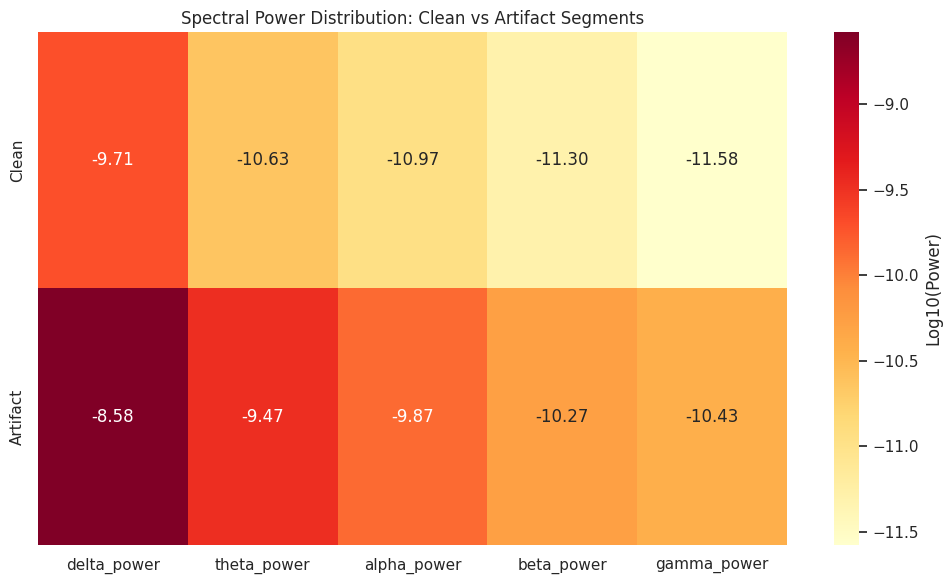

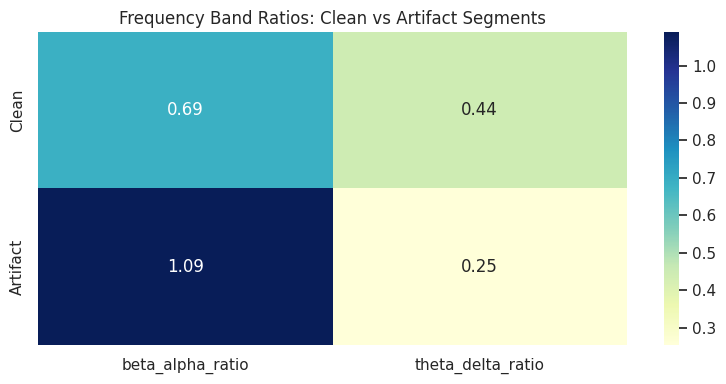

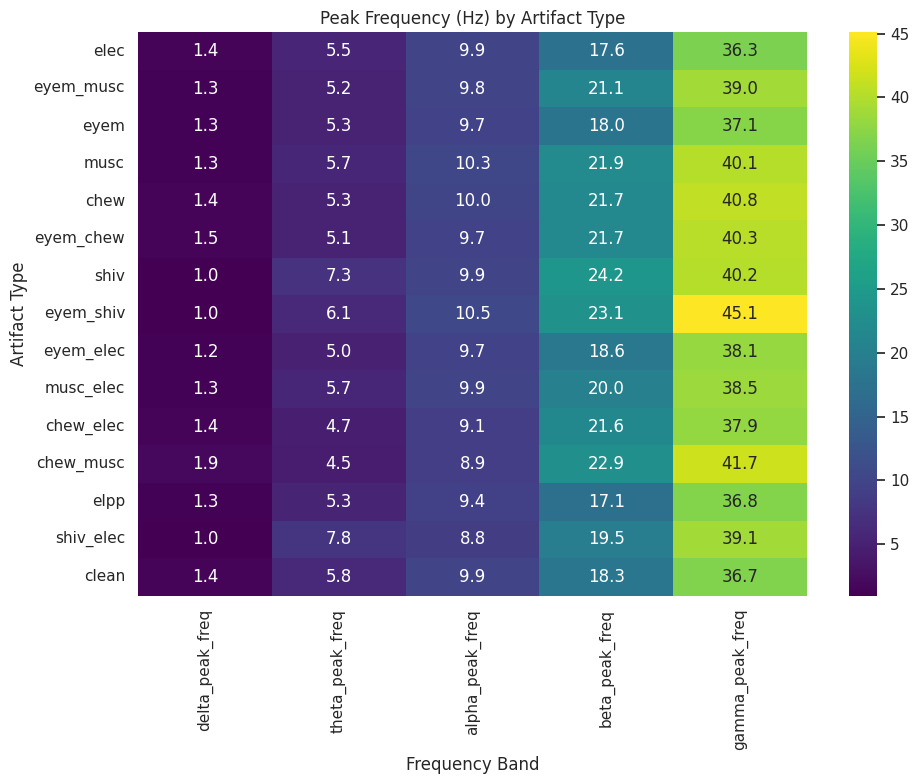

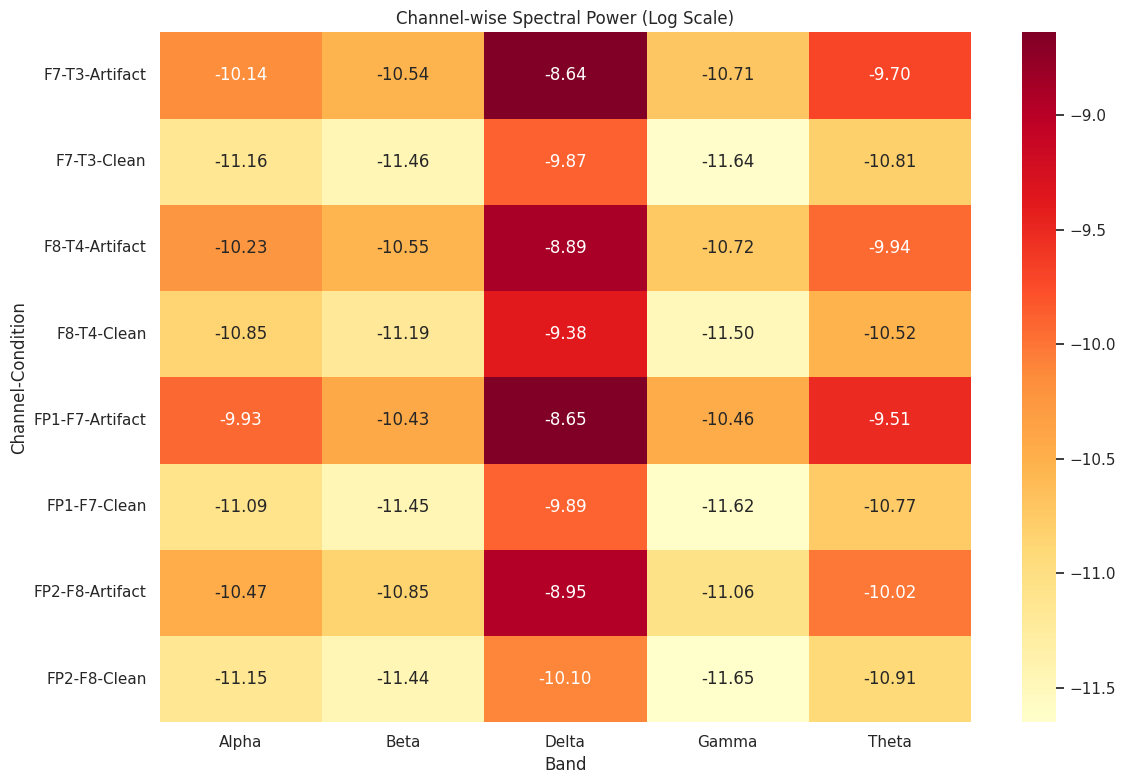

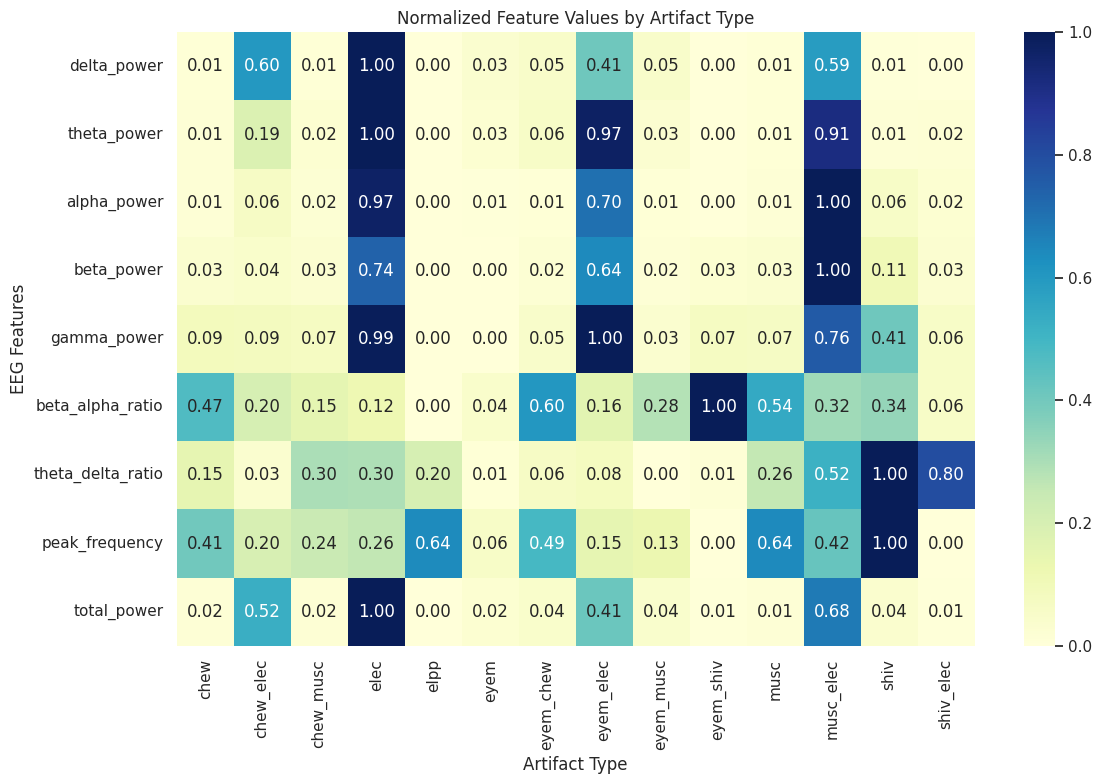

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load the data
df = pd.read_csv('/kaggle/working/balanced_artifact_features.csv')

# Separate clean and artifact segments
clean_df = df[df['is_artifact'] == 0]
artifact_df = df[df['is_artifact'] == 1]

# Set up the visualization style
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# 1. Spectral Power Distribution Heatmap
power_features = ['delta_power', 'theta_power', 'alpha_power', 'beta_power', 'gamma_power']
clean_power_means = clean_df[power_features].mean()
artifact_power_means = artifact_df[power_features].mean()

power_comparison = pd.DataFrame({
    'Clean': clean_power_means,
    'Artifact': artifact_power_means
}).T

power_comparison_log = np.log10(power_comparison + 1e-12)  # Add small value to avoid log(0)

plt.figure(figsize=(10, 6))
sns.heatmap(power_comparison_log, annot=True, fmt=".2f", cmap="YlOrRd", 
            cbar_kws={'label': 'Log10(Power)'})
plt.title('Spectral Power Distribution: Clean vs Artifact Segments')
plt.tight_layout()
plt.show()

# 2. Frequency Band Ratios Heatmap
ratio_features = ['beta_alpha_ratio', 'theta_delta_ratio']
clean_ratio_means = clean_df[ratio_features].mean()
artifact_ratio_means = artifact_df[ratio_features].mean()

ratio_comparison = pd.DataFrame({
    'Clean': clean_ratio_means,
    'Artifact': artifact_ratio_means
}).T

plt.figure(figsize=(8, 4))
sns.heatmap(ratio_comparison, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('Frequency Band Ratios: Clean vs Artifact Segments')
plt.tight_layout()
plt.show()

# 3. Peak Frequency Distribution by Artifact Type
artifact_types = artifact_df['artifact_type'].unique()
freq_bands = ['delta_peak_freq', 'theta_peak_freq', 'alpha_peak_freq', 
              'beta_peak_freq', 'gamma_peak_freq']

peak_freq_data = []
for artifact in artifact_types:
    subset = artifact_df[artifact_df['artifact_type'] == artifact]
    means = subset[freq_bands].mean()
    peak_freq_data.append(means)
    
peak_freq_df = pd.DataFrame(peak_freq_data, index=artifact_types)

# Add clean segments for comparison
clean_means = clean_df[freq_bands].mean()
peak_freq_df.loc['clean'] = clean_means

plt.figure(figsize=(10, 8))
sns.heatmap(peak_freq_df, annot=True, fmt=".1f", cmap="viridis")
plt.title('Peak Frequency (Hz) by Artifact Type')
plt.ylabel('Artifact Type')
plt.xlabel('Frequency Band')
plt.tight_layout()
plt.show()

# 4. Channel-wise Spectral Differences
common_channels = ['FP1-F7', 'FP2-F8', 'F7-T3', 'F8-T4']

channel_data = []
for channel in common_channels:
    clean_channel = clean_df[clean_df['channel'] == channel][power_features].mean()
    artifact_channel = artifact_df[artifact_df['channel'] == channel][power_features].mean()
    channel_data.append(pd.DataFrame({
        'Channel': channel,
        'Condition': 'Clean',
        'Delta': clean_channel['delta_power'],
        'Theta': clean_channel['theta_power'],
        'Alpha': clean_channel['alpha_power'],
        'Beta': clean_channel['beta_power'],
        'Gamma': clean_channel['gamma_power']
    }, index=[0]))
    channel_data.append(pd.DataFrame({
        'Channel': channel,
        'Condition': 'Artifact',
        'Delta': artifact_channel['delta_power'],
        'Theta': artifact_channel['theta_power'],
        'Alpha': artifact_channel['alpha_power'],
        'Beta': artifact_channel['beta_power'],
        'Gamma': artifact_channel['gamma_power']
    }, index=[0]))

channel_df = pd.concat(channel_data)
melted_df = channel_df.melt(id_vars=['Channel', 'Condition'], 
                           var_name='Band', 
                           value_name='Power')

# Pivot for heatmap
pivot_df = melted_df.pivot_table(index=['Channel', 'Condition'], 
                                columns='Band', 
                                values='Power')

plt.figure(figsize=(12, 8))
sns.heatmap(np.log10(pivot_df + 1e-12), cmap="YlOrRd", annot=True, fmt=".2f")
plt.title('Channel-wise Spectral Power (Log Scale)')
plt.tight_layout()
plt.show()

# 5. Combined Artifact Characterization Heatmap (Bonus)
artifact_features = power_features + ratio_features + ['peak_frequency', 'total_power']
artifact_means = artifact_df.groupby('artifact_type')[artifact_features].mean()

# Normalize for visualization
artifact_norm = artifact_means.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=0)

plt.figure(figsize=(12, 8))
sns.heatmap(artifact_norm.T, cmap="YlGnBu", annot=True, fmt=".2f")
plt.title('Normalized Feature Values by Artifact Type')
plt.ylabel('EEG Features')
plt.xlabel('Artifact Type')
plt.tight_layout()
plt.show()

Visualization comparing EEG spectral power between clean data and artifacts, showing artifact-specific spectral signatures, and displaying statistical characteristics of different artifact types.

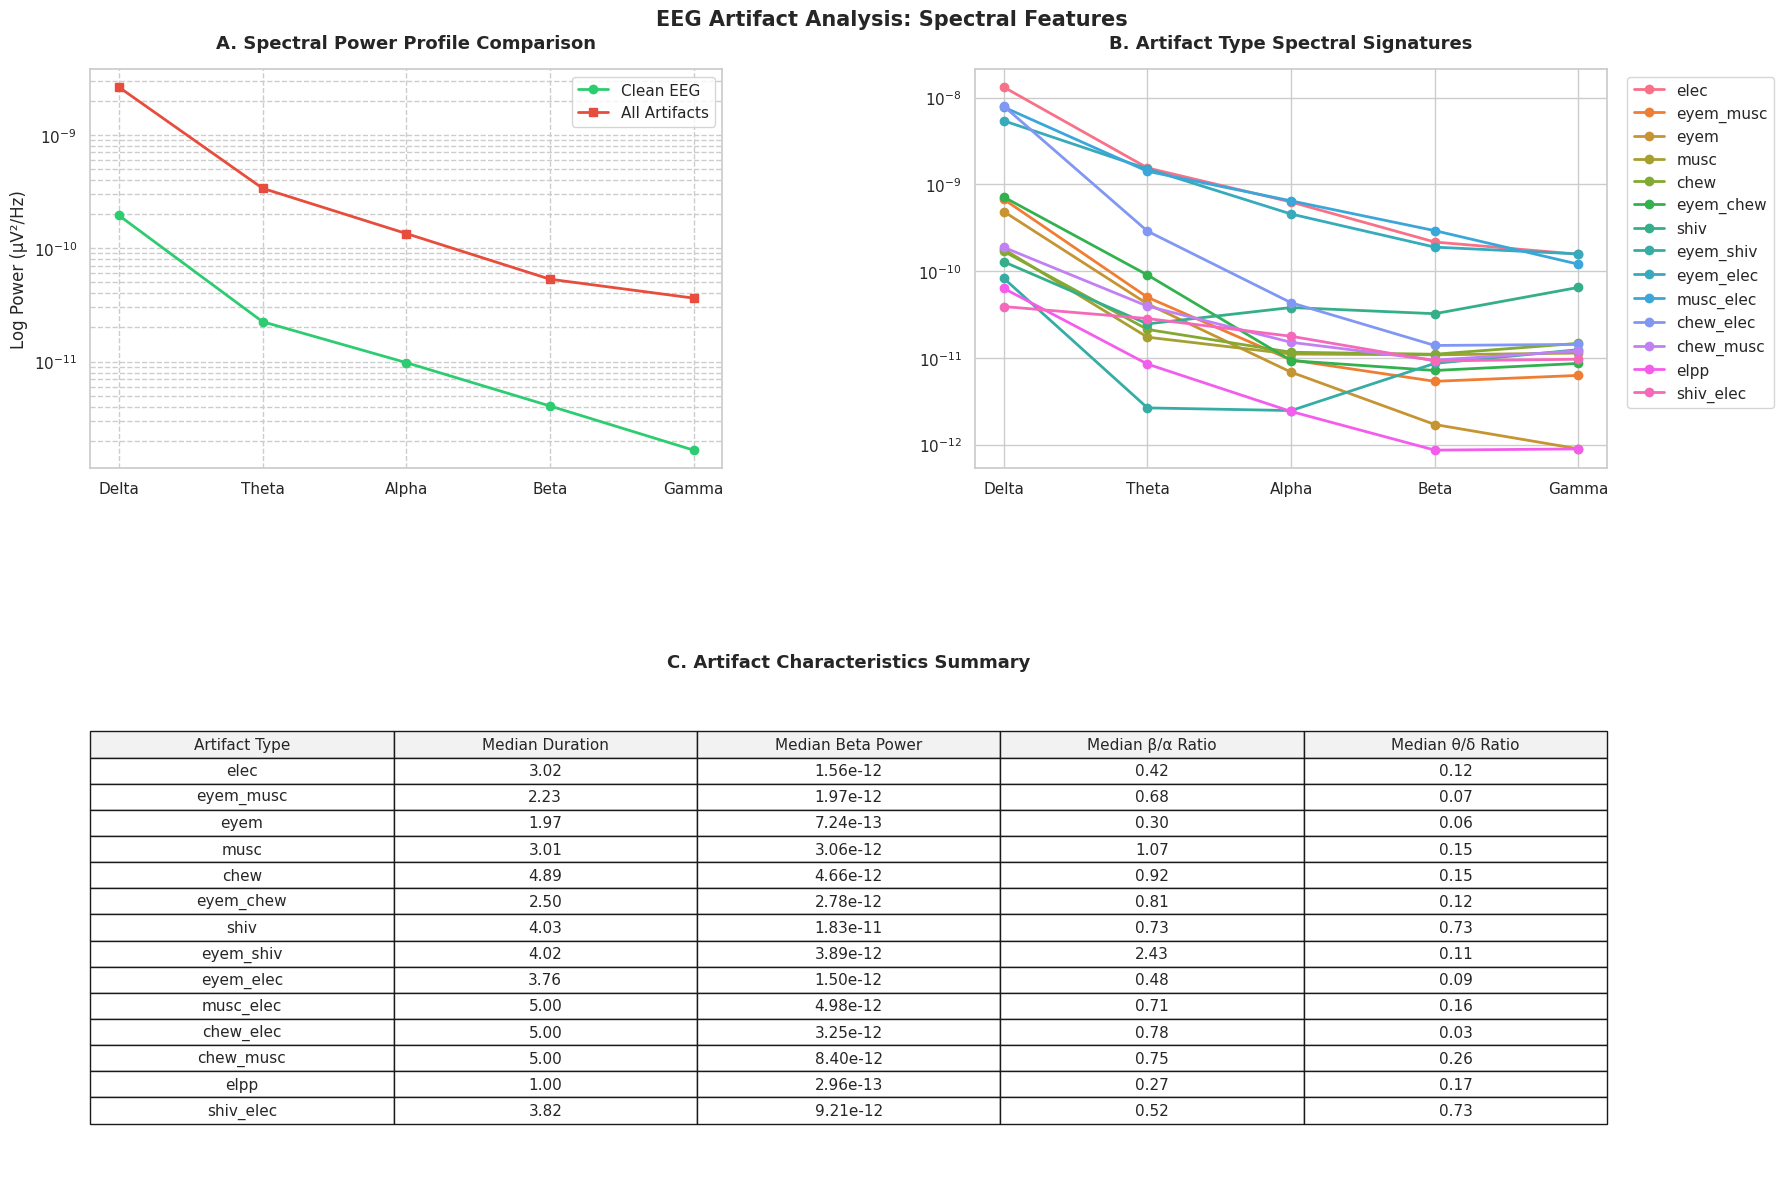

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

# Load and prepare data
df = pd.read_csv('/kaggle/working/balanced_artifact_features.csv')
clean_df = df[df['is_artifact'] == 0]
artifact_df = df[df['is_artifact'] == 1]

# Get unique artifact types and set colors
artifact_types = artifact_df['artifact_type'].unique().tolist()
colors = sns.color_palette("husl", len(artifact_types)) if artifact_types else ['#3498db']
freq_bands = ['Delta', 'Theta', 'Alpha', 'Beta', 'Gamma']

# Create figure with adjusted layout
plt.figure(figsize=(18, 12))
gs = GridSpec(2, 2, height_ratios=[1, 1.2])

# 1. Spectral Power Profile Comparison (Top Left)
ax1 = plt.subplot(gs[0, 0])
if not clean_df.empty and not artifact_df.empty:
    clean_power = clean_df[['delta_power', 'theta_power', 'alpha_power', 'beta_power', 'gamma_power']].mean()
    artifact_power = artifact_df[['delta_power', 'theta_power', 'alpha_power', 'beta_power', 'gamma_power']].mean()
    
    ax1.plot(freq_bands, clean_power, marker='o', label='Clean EEG', linewidth=2, color='#2ecc71')
    ax1.plot(freq_bands, artifact_power, marker='s', label='All Artifacts', linewidth=2, color='#e74c3c')

ax1.set_yscale('log')
ax1.set_title('A. Spectral Power Profile Comparison', pad=15, fontsize=13, fontweight='bold')
ax1.set_ylabel('Log Power (µV²/Hz)')
ax1.legend()
ax1.grid(True, which="both", ls="--")

# 2. Artifact Type Spectral Signatures (Top Right)
ax2 = plt.subplot(gs[0, 1])
if artifact_types:
    for i, artifact in enumerate(artifact_types):
        subset = artifact_df[artifact_df['artifact_type'] == artifact]
        if not subset.empty:
            power_means = subset[['delta_power', 'theta_power', 'alpha_power', 'beta_power', 'gamma_power']].mean()
            ax2.plot(freq_bands, power_means, marker='o', label=artifact, linewidth=2, color=colors[i])

ax2.set_title('B. Artifact Type Spectral Signatures', pad=15, fontsize=13, fontweight='bold')
ax2.set_yscale('log')
ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.grid(True)

# 3. Statistics Table (Bottom Center)
ax3 = plt.subplot(gs[1, :])
ax3.axis('off')

if artifact_types:
    stats_data = []
    for artifact in artifact_types:
        subset = artifact_df[artifact_df['artifact_type'] == artifact]
        if not subset.empty:
            stats_data.append([
                artifact,
                f"{subset['duration'].median():.2f}",
                f"{subset['beta_power'].median():.2e}",
                f"{subset['beta_alpha_ratio'].median():.2f}",
                f"{subset['theta_delta_ratio'].median():.2f}"
            ])
    
    if stats_data:
        table = ax3.table(cellText=stats_data,
                         colLabels=['Artifact Type', 'Median Duration', 'Median Beta Power', 
                                   'Median β/α Ratio', 'Median θ/δ Ratio'],
                         loc='center',
                         cellLoc='center',
                         colColours=['#f2f2f2']*5)
        table.auto_set_font_size(False)
        table.set_fontsize(11)
        table.scale(1, 1.5)

ax3.set_title('C. Artifact Characteristics Summary', pad=15, fontsize=13, fontweight='bold')

plt.tight_layout()
plt.subplots_adjust(top=0.93, hspace=0.5, wspace=0.4)
plt.suptitle('EEG Artifact Analysis: Spectral Features', fontsize=15, fontweight='bold', y=0.98)
plt.show()

TO GENERATED CLEAN WAVELET FILE


In [3]:
import os
import mne
import numpy as np
import pandas as pd
import pywt
import matplotlib.pyplot as plt
from scipy import signal

# === File paths ===
edf_path = '/kaggle/input/eeg-signals-edf-dataset/edf/01_tcp_ar/aaaaaaju_s005_t000.edf'
artifact_csv_path = '/kaggle/input/eeg-signals-edf-dataset/edf/01_tcp_ar/aaaaaaju_s005_t000.csv'
output_dir = '/kaggle/working/artifact_removal'
output_fif_path = os.path.join(output_dir, 'cleaned_wavelet_improved.fif')

# === Create directory if it doesn't exist ===
os.makedirs(output_dir, exist_ok=True)

# === Load data ===
raw = mne.io.read_raw_edf(edf_path, preload=True)
raw.pick_types(eeg=True)

# === Load Artifact Annotations ===
df_artifacts = pd.read_csv(artifact_csv_path, comment='#')
artifact_annots = mne.Annotations(
    onset=df_artifacts['start_time'],
    duration=df_artifacts['stop_time'] - df_artifacts['start_time'],
    description=df_artifacts['label']
)
raw.set_annotations(artifact_annots)

# === Improved Wavelet-based Cleaning Function ===
def wavelet_clean(data, sfreq, wavelet='db4', level=4, threshold_mode='soft', 
                  threshold_multiplier=2.0, preserve_high_freq=True):
    """
    Apply wavelet denoising while preserving more signal characteristics.
    """
    cleaned_data = np.zeros_like(data)
    
    for ch_idx in range(data.shape[0]):
        # Wavelet decomposition
        coeffs = pywt.wavedec(data[ch_idx], wavelet, level=level)
        
        # Apply thresholding but be less aggressive
        for i in range(1, len(coeffs)):
            # Calculate threshold for this level
            if preserve_high_freq:
                level_multiplier = threshold_multiplier * (0.8 ** (len(coeffs) - i - 1))
            else:
                level_multiplier = threshold_multiplier
            
            # Handle empty coefficients
            if len(coeffs[i]) == 0:
                continue
                
            # Calculate threshold using MAD estimator
            mad = np.median(np.abs(coeffs[i] - np.median(coeffs[i])))
            if mad == 0:  # Avoid division by zero
                thresh = 0
            else:
                thresh = level_multiplier * mad / 0.6745
            
            # Apply thresholding
            if threshold_mode == 'soft':
                coeffs[i] = pywt.threshold(coeffs[i], thresh, mode='soft')
            else:
                coeffs[i] = pywt.threshold(coeffs[i], thresh, mode='hard')
        
        # Reconstruct signal
        cleaned_data[ch_idx] = pywt.waverec(coeffs, wavelet)
    
    return cleaned_data

# === Apply improved wavelet cleaning ===
data = raw.get_data()
sfreq = raw.info['sfreq']

# Suppress wavelet warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="pywt")

cleaned_data = wavelet_clean(
    data, 
    sfreq, 
    wavelet='sym8',
    level=5,
    threshold_mode='soft',
    threshold_multiplier=1.5,
    preserve_high_freq=True
)

# === Create new Raw object with cleaned data ===
raw_cleaned = mne.io.RawArray(cleaned_data, raw.info.copy())
raw_cleaned.set_annotations(raw.annotations.copy())

# === Save the improved clean data ===
raw_cleaned.save(output_fif_path, overwrite=True)

# === Plot both versions for comparison ===
channel_idx = 0
channel_name = raw.ch_names[channel_idx]

plt.figure(figsize=(12, 8))
plt.subplot(211)
plt.plot(raw.times[:5000], raw.get_data(picks=channel_idx)[0,:5000])
plt.title(f'Original - Channel: {channel_name}')
plt.subplot(212)
plt.plot(raw_cleaned.times[:5000], raw_cleaned.get_data(picks=channel_idx)[0,:5000])
plt.title(f'Cleaned - Channel: {channel_name}')
plt.tight_layout()
plt.show()

Extracting EDF parameters from /kaggle/input/eeg-signals-edf-dataset/edf/01_tcp_ar/aaaaaaju_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=36, n_times=360500
    Range : 0 ... 360499 =      0.000 ...  1441.996 secs
Ready.


/usr/local/lib/python3.11/dist-packages/pywt/_thresholding.py:22: RuntimeWarning: invalid value encountered in divide
  thresholded = (1 - value/magnitude)
/tmp/ipykernel_31/426579740.py:100: RuntimeWarning: This filename (/kaggle/working/artifact_removal/cleaned_wavelet_improved.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_cleaned.save(output_fif_path, overwrite=True)


FileNotFoundError: parent directory does not exist: "/kaggle/working/artifact_removal"

PLOTTING ORIGINAL SIGNAL

Extracting EDF parameters from /kaggle/input/eeg-signals-edf-dataset/edf/01_tcp_ar/aaaaaaju_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
<Info | 8 non-empty values
 bads: []
 ch_names: EEG FP1-REF, EEG FP2-REF, EEG F3-REF, EEG F4-REF, EEG C3-REF, ...
 chs: 36 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2010-01-01 00:00:00 UTC
 nchan: 36
 projs: []
 sfreq: 250.0 Hz
 subject_info: <subject_info | his_id: aaaaaaju, sex: 1, last_name: aaaaaaju>
>
Available EEG Channels: ['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF', 'EEG T6-REF', 'EEG A1-REF', 'EEG A2-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF', 'EEG RO

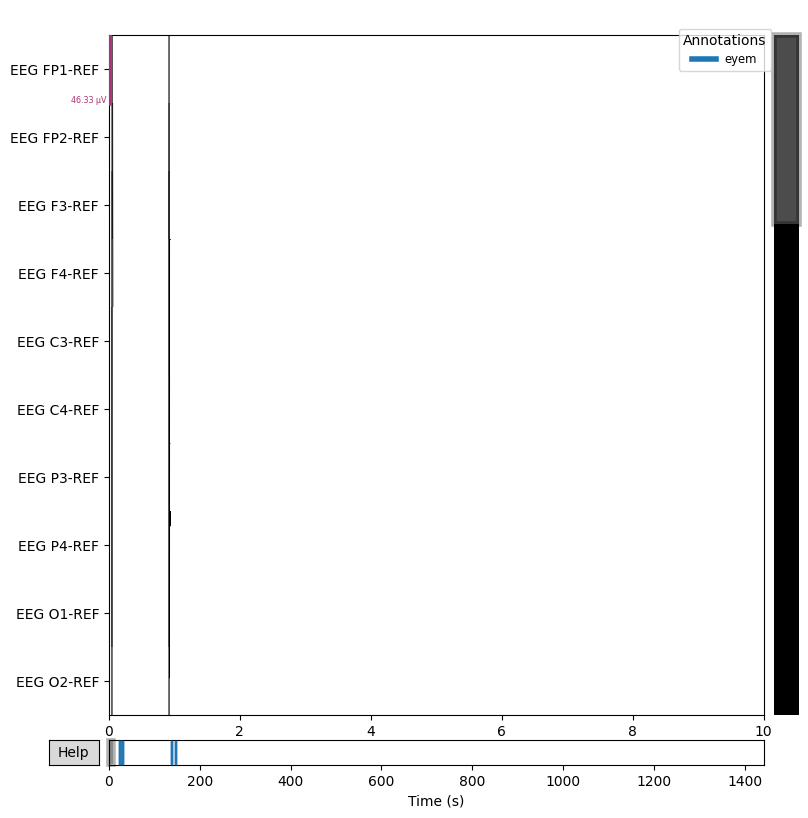

In [5]:
import mne
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from mne.viz.utils import _get_color_list

# --- Load data ---
edf_path = '/kaggle/input/eeg-signals-edf-dataset/edf/01_tcp_ar/aaaaaaju_s005_t000.edf'
artifact_csv_path = '/kaggle/input/eeg-signals-edf-dataset/edf/01_tcp_ar/aaaaaaju_s005_t000.csv'

raw = mne.io.read_raw_edf(edf_path, preload=True)
raw.pick_types(eeg=True)

# Check if data is loaded correctly
print(raw.info)
print("Available EEG Channels:", raw.info['ch_names'])

# --- Load artifact annotations ---
df_art = pd.read_csv(artifact_csv_path, comment='#')
print("Artifact Annotations DataFrame:")
print(df_art.head())  # Check if the dataframe contains data

# Check if annotations are present in the DataFrame
if not df_art.empty:
    art_annots = mne.Annotations(
        onset=df_art['start_time'],
        duration=df_art['stop_time'] - df_art['start_time'],
        description=df_art['label'].tolist()
    )
    raw.set_annotations(art_annots)
    print("Annotations added:", raw.annotations)
else:
    print("No artifact annotations found!")

# --- Plot raw EEG with annotations ---
fig = raw.plot(
    n_channels=10,
    scalings='auto',
    title='EEG with Artifacts (No Seizures)',
    show=False  # We'll show it after adding legend
)

# --- Create legend ---
descs = list(dict.fromkeys(raw.annotations.description))
colors = _get_color_list()
color_map = {desc: colors[i % len(colors)] for i, desc in enumerate(descs)}

# Create a separate axis for the legend
legend_ax = fig.add_axes([0.82, 0.9, 0.15, 0.1])  # [left, bottom, width, height]
legend_ax.axis('off')

# Create legend handles
handles = [Line2D([0], [0], color=color_map[desc], lw=4, label=desc) for desc in descs]

# Add legend to the dedicated axis
legend_ax.legend(
    handles=handles,
    loc='center',
    frameon=True,
    title='Annotations',
    fontsize='small'
)

plt.show()

ARTIFACT REMOVAL

Extracting EDF parameters from /kaggle/input/eeg-signals-edf-dataset/edf/01_tcp_ar/aaaaaaju_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Opening raw data file /kaggle/working/artifact_removal/cleaned_wavelet_improved.fif...
Isotrak not found
    Range : 0 ... 360499 =      0.000 ...  1441.996 secs
Ready.
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...


/tmp/ipykernel_31/1631497951.py:13: RuntimeWarning: This filename (/kaggle/working/artifact_removal/cleaned_wavelet_improved.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw_cleaned = mne.io.read_raw_fif(fif_path, preload=True)  # Load your cleaned data
/usr/local/lib/python3.11/dist-packages/mne/viz/utils.py:1410: RuntimeWarning: Mean of empty slice
  this_data -= np.nanmean(this_data, 0)  # subtract segment means


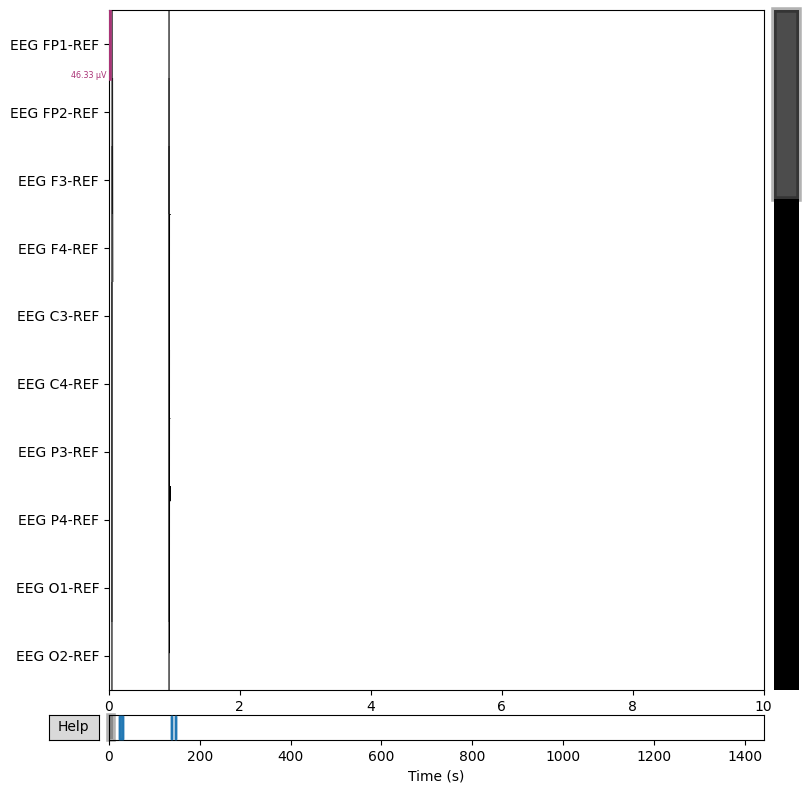

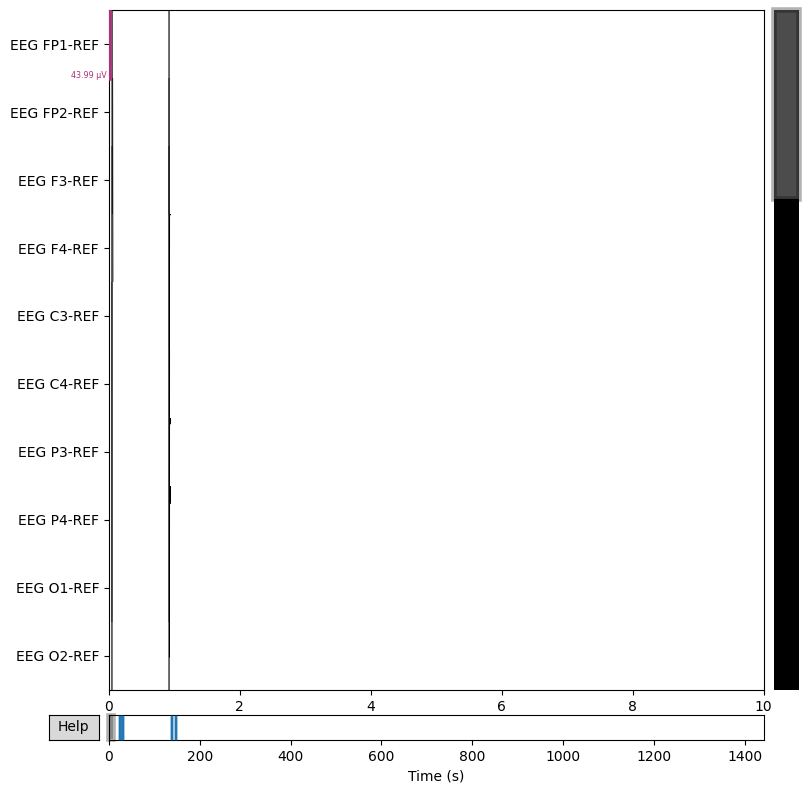

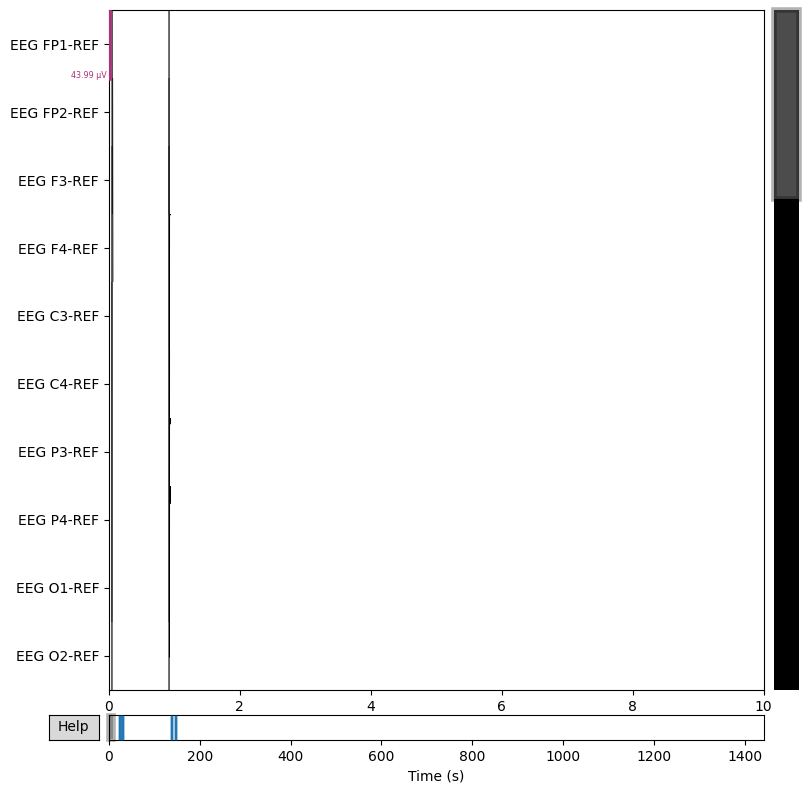

In [6]:
import mne
import pandas as pd

# === File paths ===
edf_path = '/kaggle/input/eeg-signals-edf-dataset/edf/01_tcp_ar/aaaaaaju_s005_t000.edf'
fif_path = '/kaggle/working/artifact_removal/cleaned_wavelet_improved.fif'  # Your cleaned FIF file
artifact_csv_path = '/kaggle/input/eeg-signals-edf-dataset/edf/01_tcp_ar/aaaaaaju_s005_t000.csv'

# === Load both datasets ===
raw_uncleaned = mne.io.read_raw_edf(edf_path, preload=True)
raw_uncleaned.pick_types(eeg=True)

raw_cleaned = mne.io.read_raw_fif(fif_path, preload=True)  # Load your cleaned data

# === Load Artifact Annotations (for the uncleaned data) ===
df_artifacts = pd.read_csv(artifact_csv_path, comment='#')
artifact_annots = mne.Annotations(
    onset=df_artifacts['start_time'],
    duration=df_artifacts['stop_time'] - df_artifacts['start_time'],
    description=df_artifacts['label']
)
raw_uncleaned.set_annotations(artifact_annots)

# === Plot both versions in separate windows ===
# Plot uncleaned data first
raw_uncleaned.plot(n_channels=10, scalings='auto', title='Uncleaned EEG', show=False)

# Then plot cleaned data in a separate window
raw_cleaned.plot(n_channels=10, scalings='auto', title='Cleaned EEG', show=True, block=True)

COMPARING CLEANED AND UNCLEANED MEAN CHECKING THE SIGNAL AFTER ARTIFACT REMOVAL

WAVELET+SPECTRAL COMPARISONS

Extracting EDF parameters from /kaggle/input/eeg-signals-edf-dataset/edf/01_tcp_ar/aaaaaaju_s005_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 360499  =      0.000 ...  1441.996 secs...
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Creating RawArray with float64 data, n_channels=36, n_times=360500
    Range : 0 ... 360499 =      0.000 ...  1441.996 secs
Ready.
Writing /kaggle/working/artifact_removal/cleaned_wavelet_improved_eeg.fif
Closing /kaggle/working/artifact_removal/cleaned_wavelet_improved_eeg.fif
[done]

===== Band Powers (Mean across channels) =====
delta_power       : BEFORE = 0.0011 | AFTER = 0.0011 | Change = +0.0000
theta_power       : BEFORE = 0.0000 | AFTER = 0.0000 | Change = +0.0000
alpha_power       : BEFORE = 0.0000 | AFTER = 0.0000 | Change = -0.0000
beta_power        : BEFORE = 0.0000 | AFTER = 0.0000 | Change = -0.0000
gamma_power       : BEFORE = 0.0000 | AFTER = 0.0000

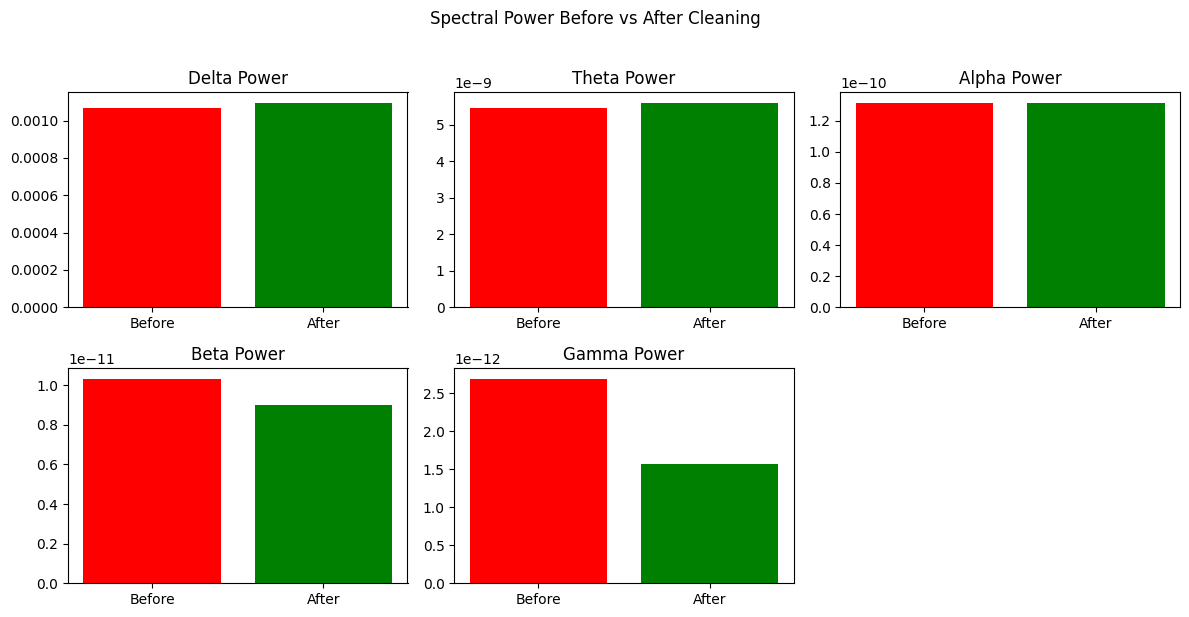

In [8]:
import os
import mne
import numpy as np
import pandas as pd
import pywt
from scipy.signal import welch
from scipy.stats import entropy
import matplotlib.pyplot as plt

# ===== File Paths =====
edf_path = '/kaggle/input/eeg-signals-edf-dataset/edf/01_tcp_ar/aaaaaaju_s005_t000.edf'
artifact_csv_path = '/kaggle/input/eeg-signals-edf-dataset/edf/01_tcp_ar/aaaaaaju_s005_t000.csv'
output_dir = '/kaggle/working/artifact_removal'  # Fixed path
output_fif_path = os.path.join(output_dir, 'cleaned_wavelet_improved_eeg.fif')  # MNE compliant name

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# ===== 1. Load EEG and Annotations =====
raw = mne.io.read_raw_edf(edf_path, preload=True)
raw.pick_types(eeg=True)

df_artifacts = pd.read_csv(artifact_csv_path, comment='#')
annotations = mne.Annotations(
    onset=df_artifacts['start_time'],
    duration=df_artifacts['stop_time'] - df_artifacts['start_time'],
    description=df_artifacts['label']
)
raw.set_annotations(annotations)

# ===== 2. Wavelet-Based Artifact Removal =====
def wavelet_clean(data, wavelet='sym8', level=5, threshold_mode='soft', threshold_multiplier=1.5):
    cleaned = np.zeros_like(data)
    for ch in range(data.shape[0]):
        coeffs = pywt.wavedec(data[ch], wavelet=wavelet, level=level)
        for i in range(1, len(coeffs)):
            # Handle potential division by zero
            mad = np.median(np.abs(coeffs[i] - np.median(coeffs[i])))
            thresh = threshold_multiplier * mad / 0.6745 if mad > 0 else 0
            coeffs[i] = pywt.threshold(coeffs[i], thresh, mode=threshold_mode)
        cleaned[ch] = pywt.waverec(coeffs, wavelet)
    return cleaned[:, :data.shape[1]]  # Trim if needed

# Suppress PyWavelets warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning, module="pywt")

raw_data = raw.get_data()
sfreq = raw.info['sfreq']
cleaned_data = wavelet_clean(raw_data)

# Create cleaned Raw object
raw_cleaned = mne.io.RawArray(cleaned_data, raw.info.copy())
raw_cleaned.set_annotations(raw.annotations.copy())

# Save with proper MNE naming convention
raw_cleaned.save(output_fif_path, overwrite=True)

# ===== 3. Spectral Feature Extraction =====
def compute_spectral_features(data, sfreq):
    freqs, psd = welch(data, fs=sfreq, nperseg=sfreq*2, axis=1)
    features = {}
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta':  (13, 30),
        'gamma': (30, 45)
    }
    for band, (low, high) in bands.items():
        idx = np.logical_and(freqs >= low, freqs <= high)
        features[f'{band}_power'] = np.mean(psd[:, idx], axis=1)
    norm_psd = psd / np.sum(psd, axis=1, keepdims=True)
    features['spectral_entropy'] = entropy(norm_psd, axis=1)
    return pd.DataFrame(features)

features_before = compute_spectral_features(raw_data, sfreq)
features_after = compute_spectral_features(cleaned_data, sfreq)

# ===== 4. Print Comparison =====
print("\n===== Band Powers (Mean across channels) =====")
for col in features_before.columns:
    before = features_before[col].mean()
    after = features_after[col].mean()
    print(f"{col:18s}: BEFORE = {before:.4f} | AFTER = {after:.4f} | Change = {after - before:+.4f}")

# ===== 5. Plotting =====
plt.figure(figsize=(12, 6))
for i, band in enumerate(['delta', 'theta', 'alpha', 'beta', 'gamma']):
    plt.subplot(2, 3, i+1)
    plt.bar(['Before', 'After'], [
        features_before[f'{band}_power'].mean(),
        features_after[f'{band}_power'].mean()
    ], color=['red', 'green'])
    plt.title(f'{band.capitalize()} Power')
plt.suptitle('Spectral Power Before vs After Cleaning', y=1.02)
plt.tight_layout()
plt.show()